In [72]:
# ! pip install pandas
# ! pip install seaborn
# ! pip install xgboost
# ! pip install scikit-optimize
# ! pip install openpyxl

In [1]:
import pandas as pd
from lib.lib import *
# Set global font properties
plt.rcParams.update({
    'font.size': 16,
    'font.family': 'Arial'
})

In [2]:
simulated_data = pd.read_excel(f'data/CNT_Growth_Rate_Simulation_with_noise.xlsx')
simulated_data.head()

Experiment Number  Temperature (Tp, °C)  Time (t, s)  \
0                  1                   600            0   
1                  1                   600            1   
2                  1                   600            2   
3                  1                   600            3   
4                  1                   600            4   

   Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
0                         0.6               0.000000  
1                         0.6               0.028338  
2                         0.6               0.076081  
3                         0.6               0.114440  
4                         0.6               0.157956

In [3]:
print(simulated_data.shape)
simulated_data.describe()

(163336, 5)


Experiment Number  Temperature (Tp, °C)    Time (t, s)  \
count      163336.000000         163336.000000  163336.000000   
mean           68.500000            800.000000     600.000000   
std            39.258877            122.474862     346.699778   
min             1.000000            600.000000       0.000000   
25%            34.750000            700.000000     300.000000   
50%            68.500000            800.000000     600.000000   
75%           102.250000            900.000000     900.000000   
max           136.000000           1000.000000    1200.000000   

       Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
count               163336.000000          163336.000000  
mean                     1.300000              21.105942  
std                      0.458259              13.560843  
min                      0.600000               0.000000  
25%                      0.950000               9.409286  
50%                      1.300000              18.133358  
75%                      1.650000              31.100267  
max                      2.000000              68.093337

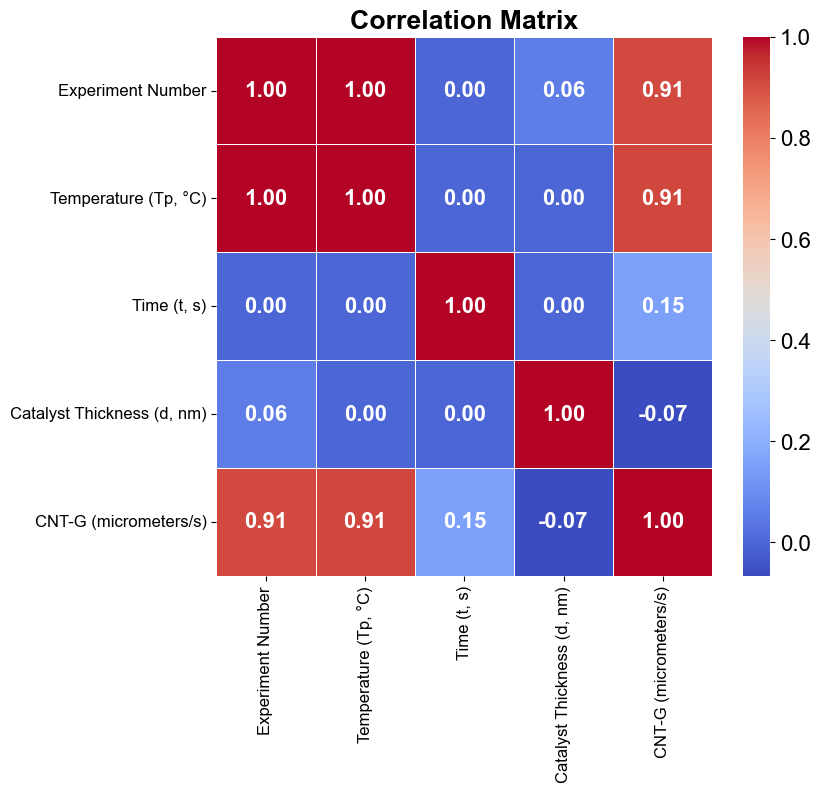

In [4]:
get_data_correlation(simulated_data)

In [5]:
original_data = pd.read_csv('data/CNTGrowthData.csv')
original_data.head()
original_data.rename(columns={
    'Run_ID': 'Experiment Number',
    'Temperature ( in C )': 'Temperature (Tp, °C)',
    'Catalyst Layer Thickness ( in nm )': 'Catalyst Thickness (d, nm)',
    'Time_s': 'Time (t, s)',
    'growth_rate': 'CNT-G (micrometers/s)'
}, inplace=True)
original_data = original_data[list(simulated_data.columns)]
original_data["Experiment Number"] = original_data["Experiment Number"] + max(simulated_data["Experiment Number"])
original_data.head()

Experiment Number  Temperature (Tp, °C)  Time (t, s)  \
0                137                   625          132   
1                137                   625          134   
2                137                   625          136   
3                137                   625          138   
4                137                   625          140   

   Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
0                           2               4.520099  
1                           2               4.490667  
2                           2               4.503352  
3                           2               4.573735  
4                           2               6.329410

In [6]:
full_dataset = pd.concat([simulated_data, original_data], axis=0)
full_dataset.shape

(167802, 5)

In [7]:
simulated_exp, total_exp = max(simulated_data["Experiment Number"]), max(full_dataset["Experiment Number"])
simulated_exp, total_exp

(136, 139)

In [8]:
target = ['CNT-G (micrometers/s)']
features = ['Temperature (Tp, °C)', 'Time (t, s)', 'Catalyst Thickness (d, nm)']

### Train on only simulated data and test simulated

In [9]:
test_experiment_numbers = [3, 19, 37, 100]

# Separate the test set
test_set = simulated_data[simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (4804, 5)


In [10]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  4
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (4804, 3)
Y_test shape: (4804, 1)


In [11]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9854948803678524
MAE CNT-G: 0.8780804719957641
MSE CNT-G: 2.003225880697813
RMSE CNT-G: 1.4153536239038684


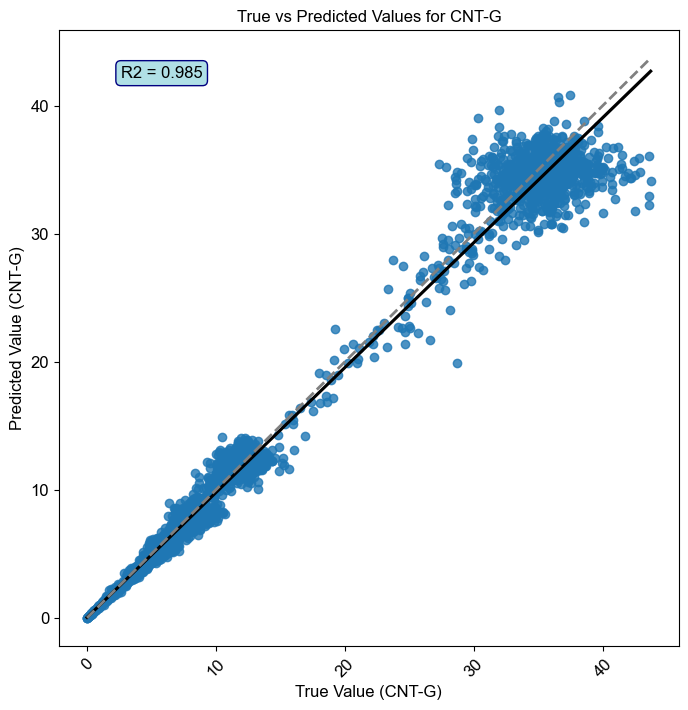

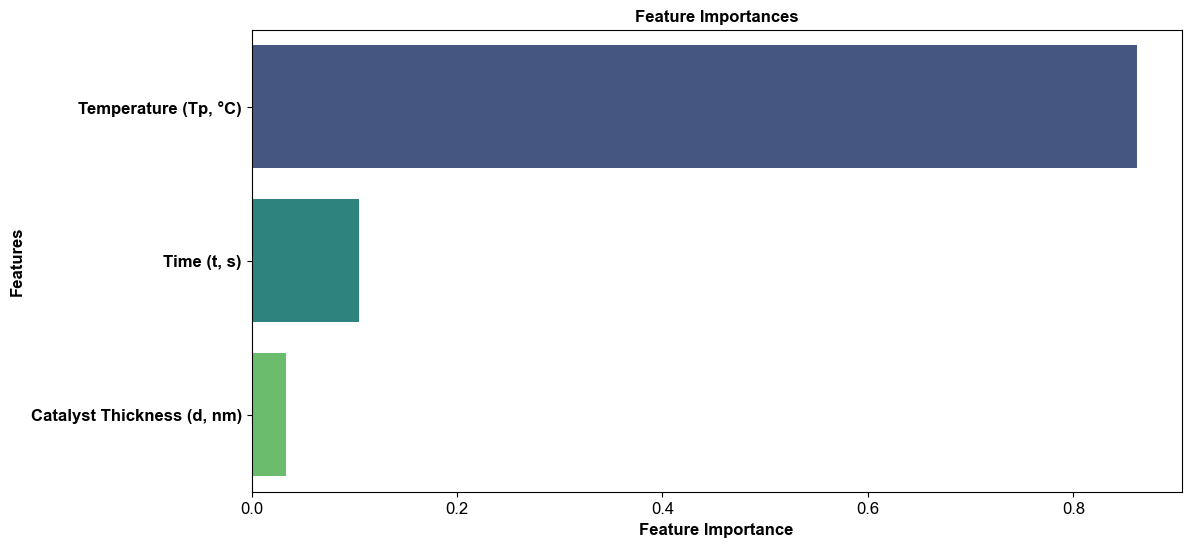

In [12]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [13]:
import re

def get_temperature_and_thickness(string):
    temperature_match = re.search(r"Temperature\s+(\d+)", string)
    thickness_match = re.search(r"Thickness\s+(\d+(?:\.\d+)?)", string)
    temperature = None
    thickness = None
    if temperature_match:
        temperature = int(temperature_match.group(1))
    if thickness_match:
        thickness = float(thickness_match.group(1))
    return temperature, thickness

string = "run the prediction for Temperature 800 and Thickness 1.27"
experiment_time_span = 20 # minutes

temperature, catalyst_thickness = get_temperature_and_thickness(string)
time_values = np.arange(0, experiment_time_span * 60 +1 , 1)

user_test_set = pd.DataFrame({
    'Temperature (Tp, °C)': [temperature] * len(time_values),
    'Time (t, s)': time_values,
    'Catalyst Thickness (d, nm)': [catalyst_thickness] * len(time_values)
})
user_test_set['CNT-G (micrometers/s)'] = rf_model.predict(user_test_set)
user_test_set.tail()

Temperature (Tp, °C)  Time (t, s)  Catalyst Thickness (d, nm)  \
1196                   800         1196                        1.27   
1197                   800         1197                        1.27   
1198                   800         1198                        1.27   
1199                   800         1199                        1.27   
1200                   800         1200                        1.27   

      CNT-G (micrometers/s)  
1196              22.514077  
1197              21.097340  
1198              21.315099  
1199              22.291901  
1200              22.124948

In [14]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)
model_prediction = xgb_model.predict(X_test)

R^2 CNT-G: 0.990364134311676
MAE CNT-G: 0.6526512557111045
MSE CNT-G: 1.3307586082685288
RMSE CNT-G: 1.1535851109773083


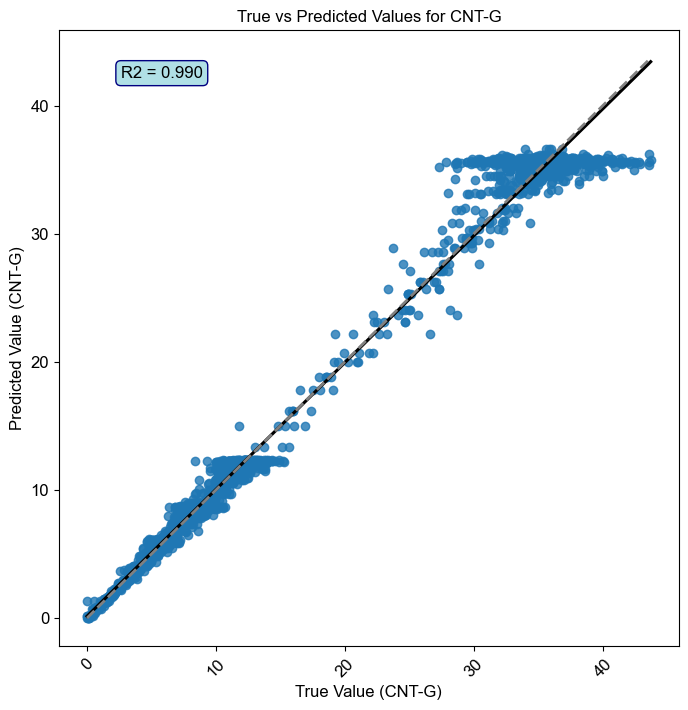

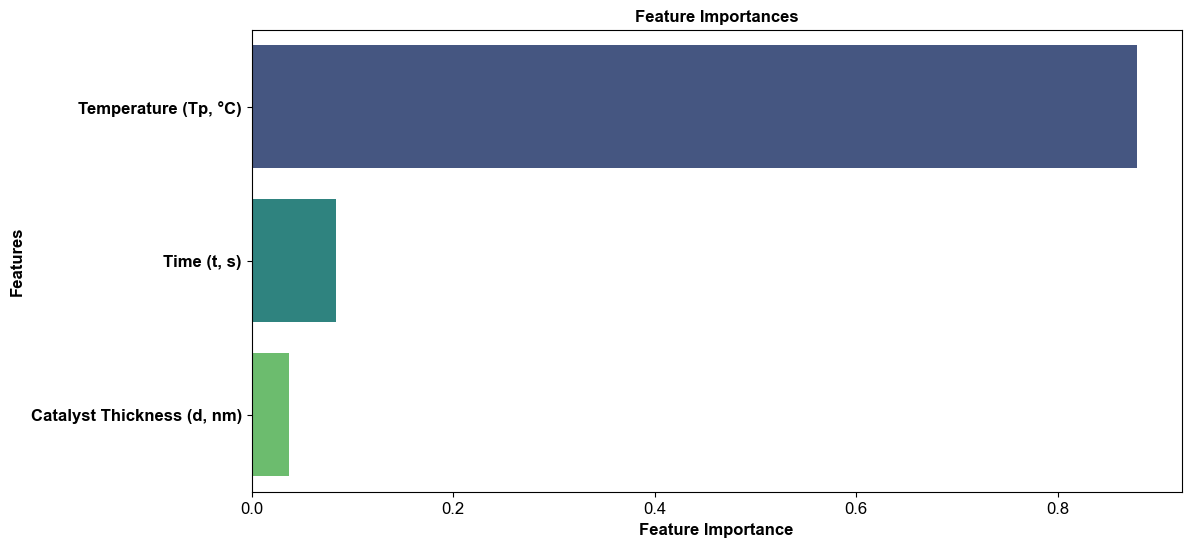

In [15]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [16]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)
model_prediction = ann_model.predict(X_test)

R^2 CNT-G: 0.8258214027516689
MAE CNT-G: 4.161757776610568
MSE CNT-G: 24.05489115016944
RMSE CNT-G: 4.904578590477416


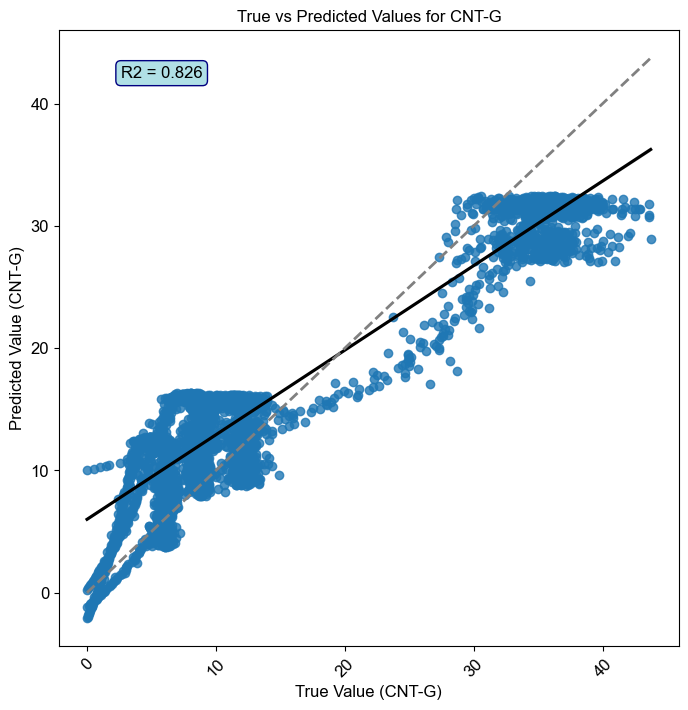

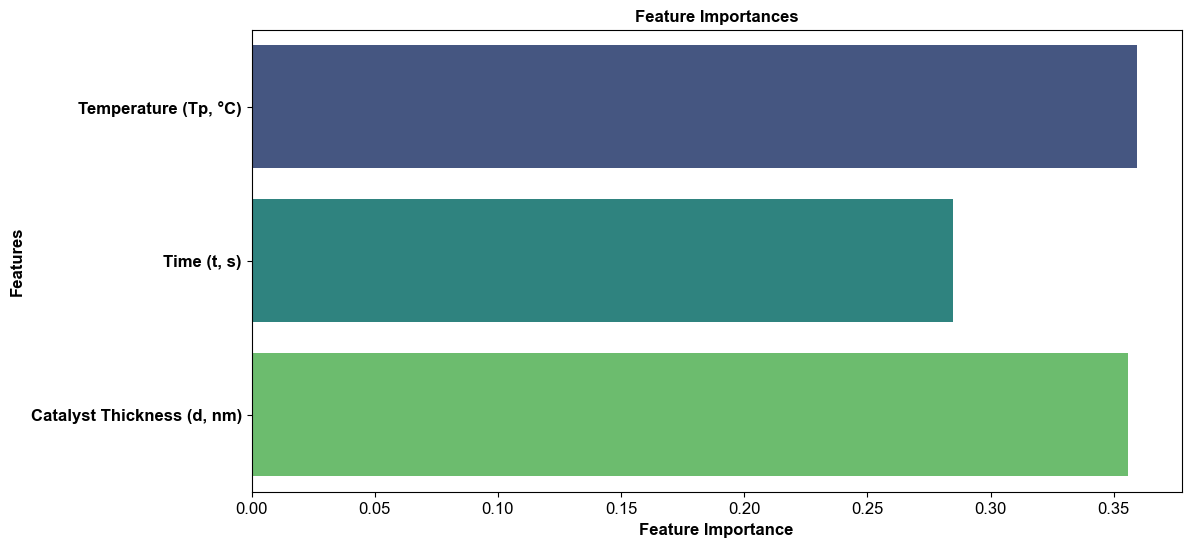

In [17]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Train on only simulated data and test both

In [18]:
test_experiment_numbers = [3, 19, 37, 100, 137, 138, 139]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (9270, 5)


In [19]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  7
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (9270, 3)
Y_test shape: (9270, 1)


In [20]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9816579240945997
MAE CNT-G: 1.0068161415850654
MSE CNT-G: 1.7968255806254787
RMSE CNT-G: 1.3404572281969607


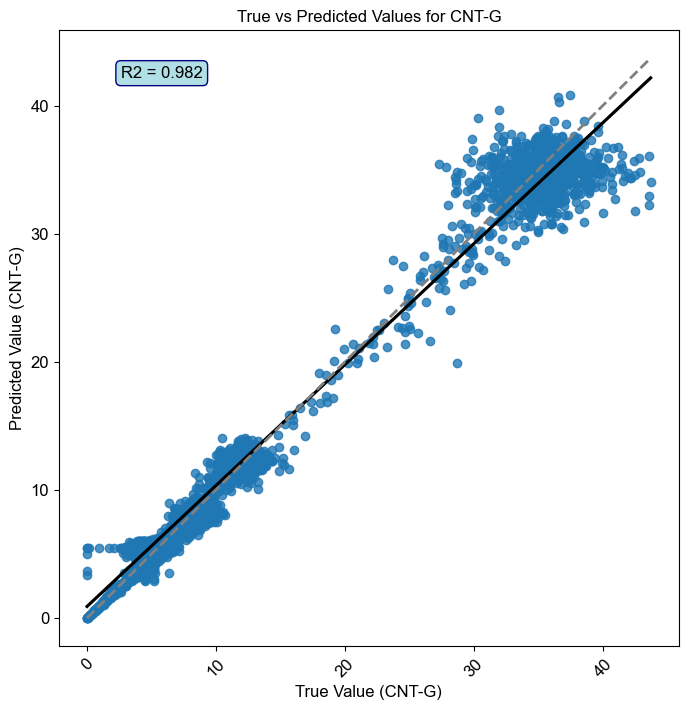

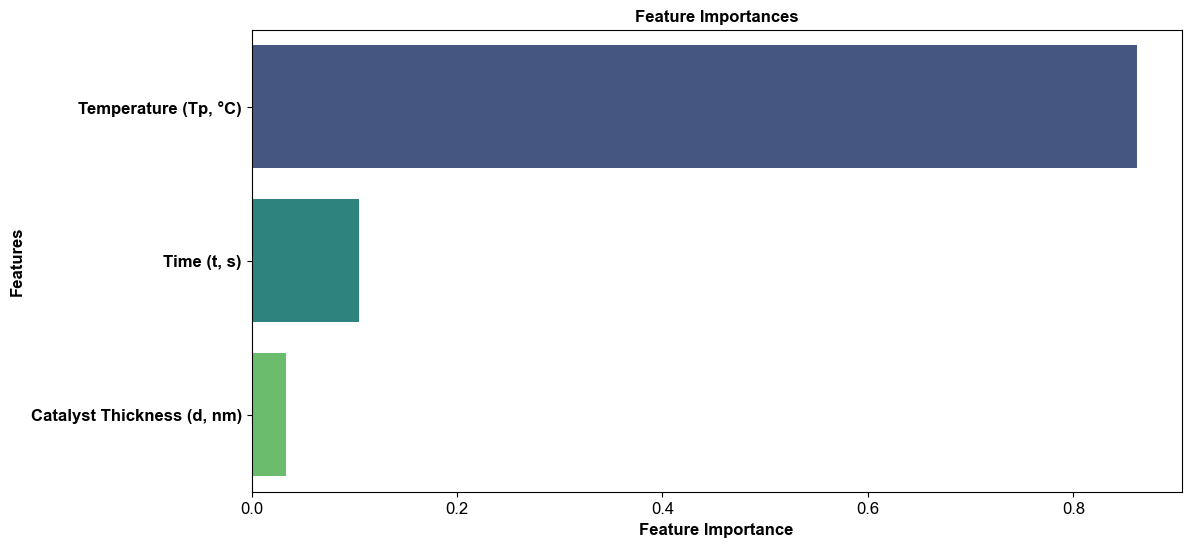

In [21]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [22]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.985904335975647
MAE CNT-G: 0.8682552176741277
MSE CNT-G: 1.3808370675464372
RMSE CNT-G: 1.1750902380440564


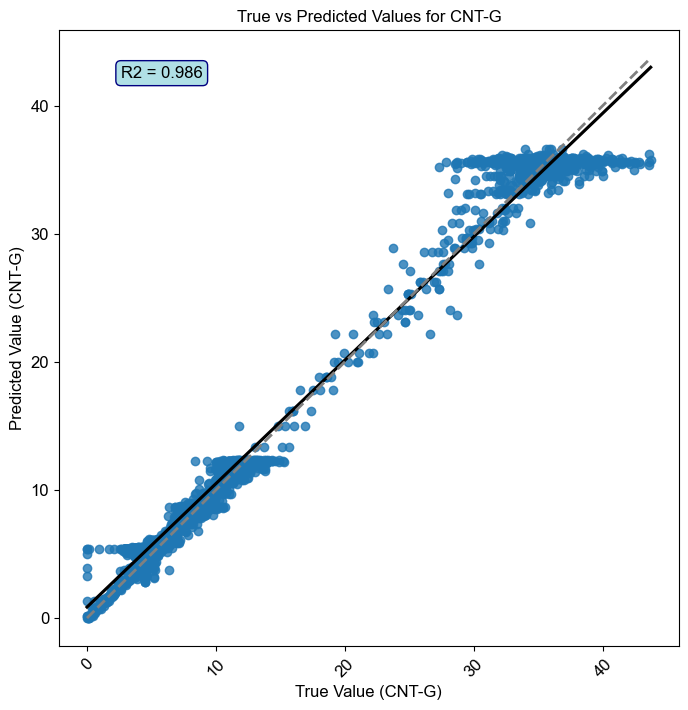

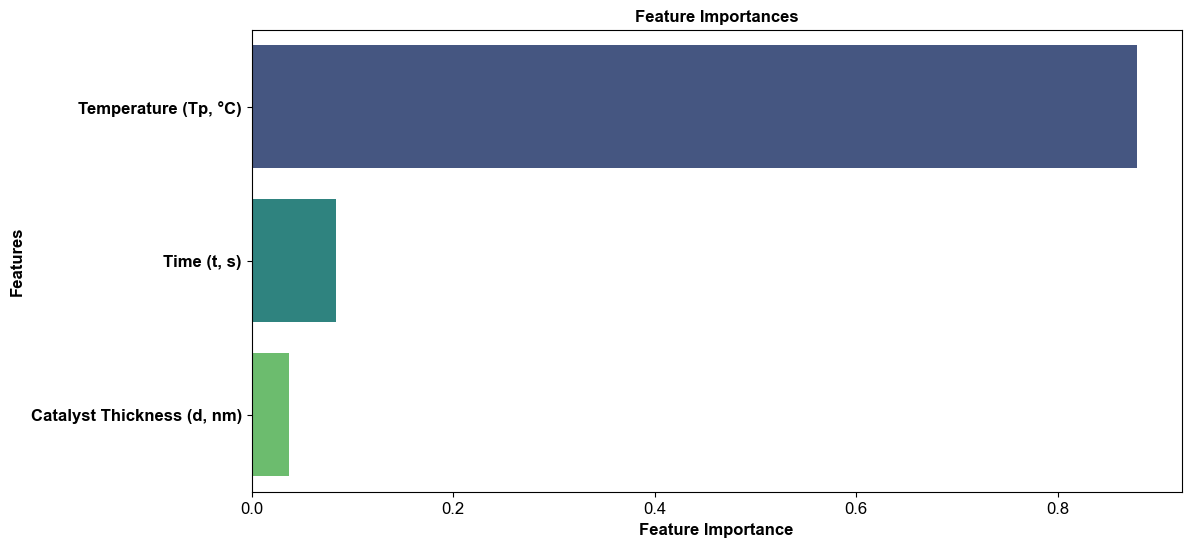

In [23]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [24]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: -13.57880100593806
MAE CNT-G: 15.447751740341195
MSE CNT-G: 1428.167821211858
RMSE CNT-G: 37.79110770024951


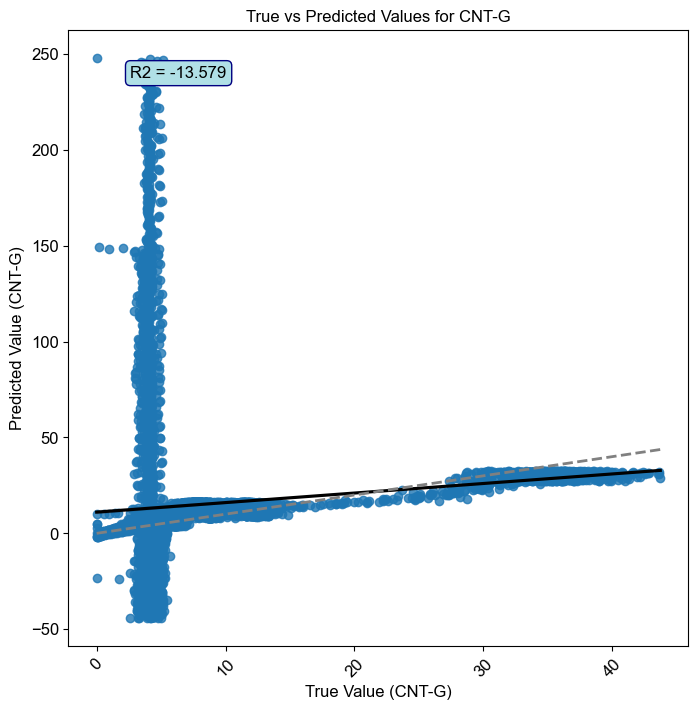

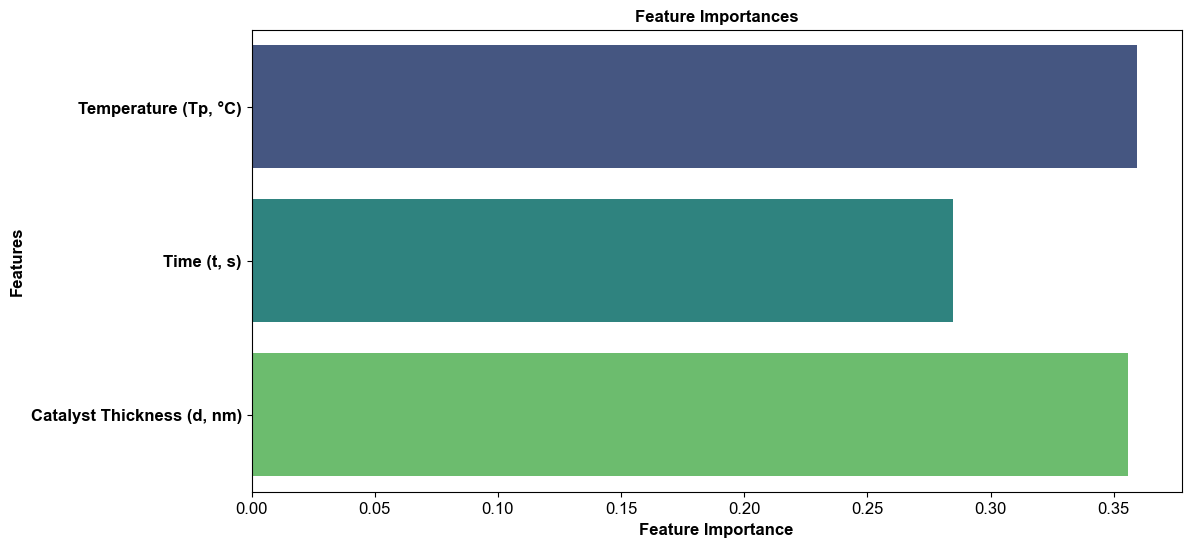

In [25]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Train with both data and test both

In [26]:
test_experiment_numbers = [3, 19, 37, 100, 138]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = full_dataset[~full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (161514, 5)
Test set shape: (6288, 5)


In [27]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  134
Number of Exp for test:  5
X_train shape: (161514, 3)
Y_train shape: (161514, 1)
X_test shape: (6288, 3)
Y_test shape: (6288, 1)


In [28]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9842986940463277
MAE CNT-G: 0.8628569241675439
MSE CNT-G: 1.952379228297187
RMSE CNT-G: 1.3972756450669235


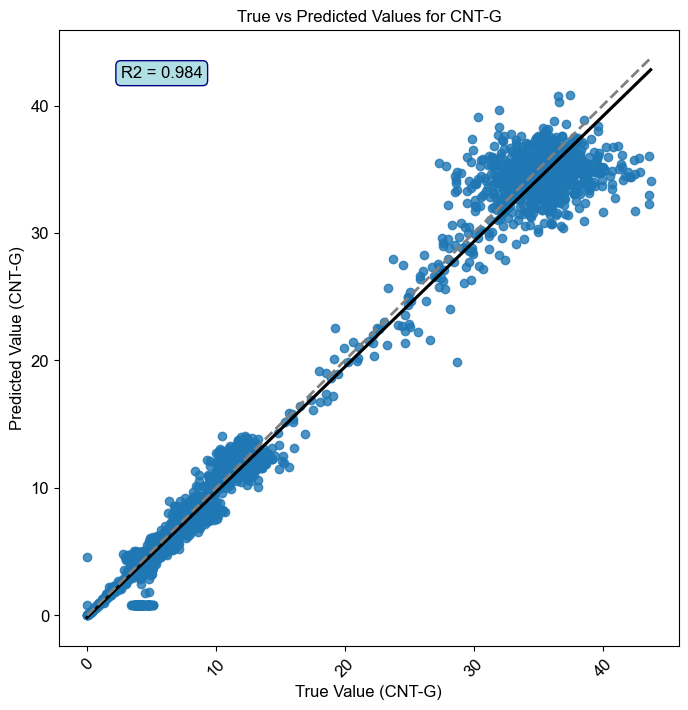

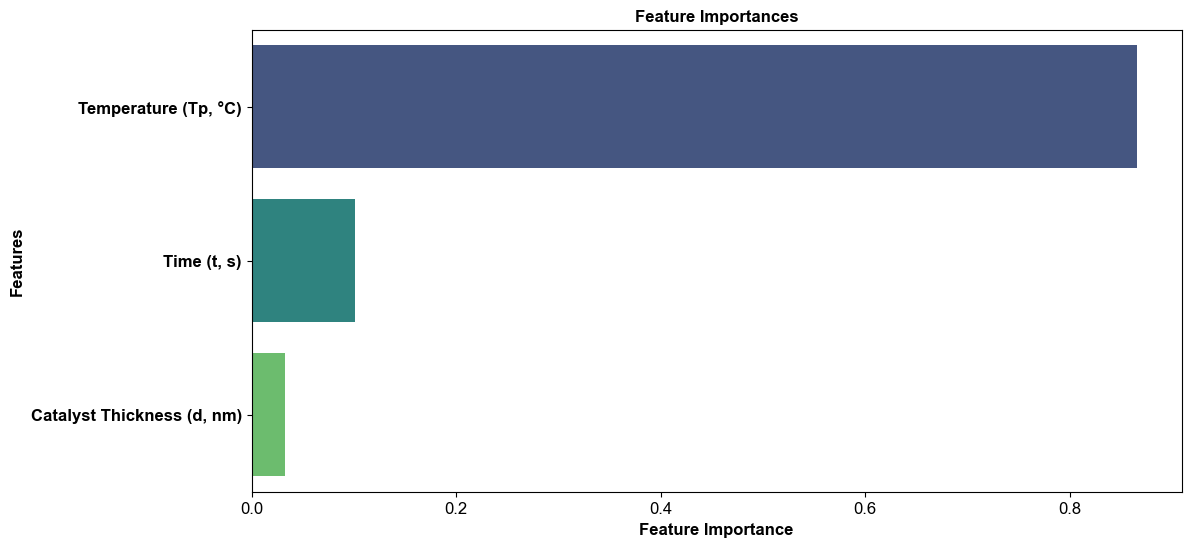

In [29]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [30]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.9911718368530273
MAE CNT-G: 0.594382294597666
MSE CNT-G: 1.0977392133364585
RMSE CNT-G: 1.0477305060636817


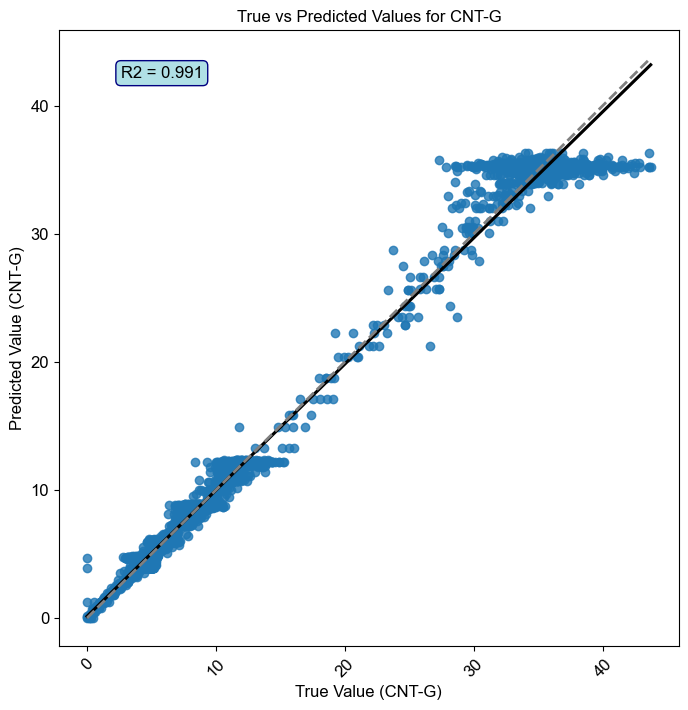

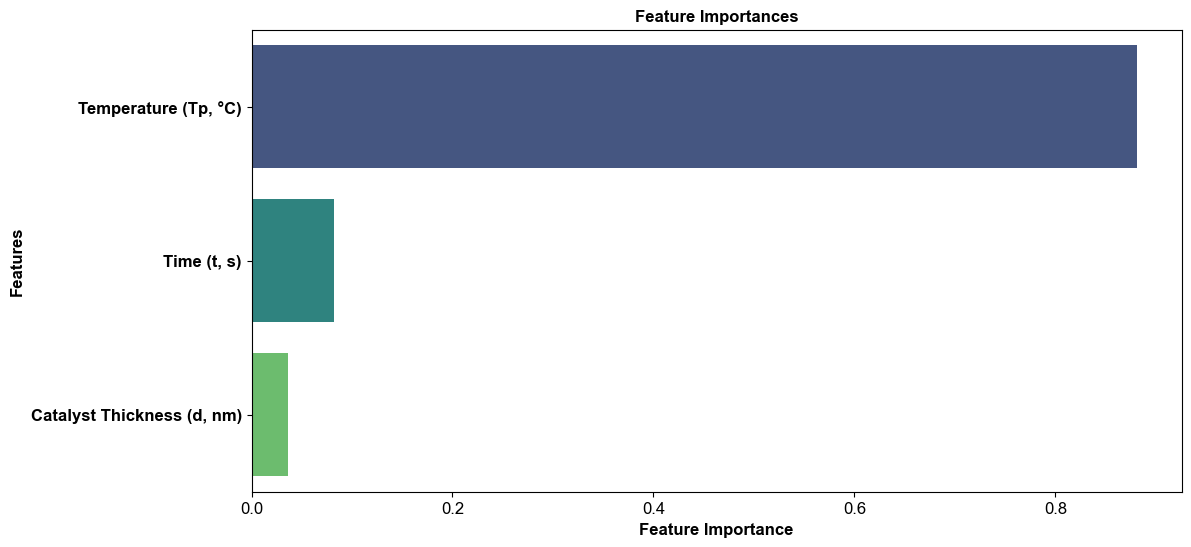

In [31]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [32]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: 0.6619056928923073
MAE CNT-G: 5.337086695948054
MSE CNT-G: 42.04034392745579
RMSE CNT-G: 6.483852552877478


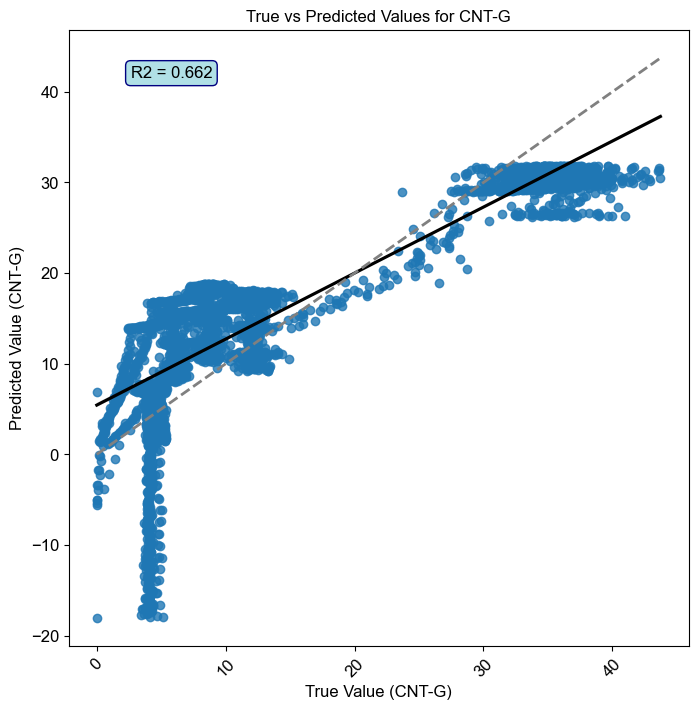

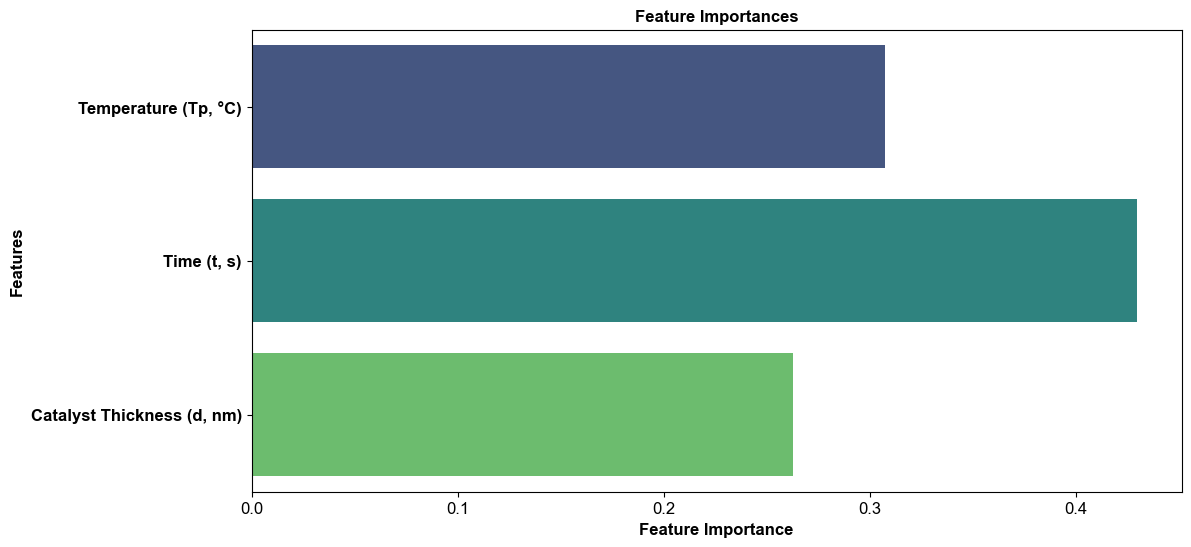

In [33]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

# With Normalization

In [34]:
full_dataset.head()

Experiment Number  Temperature (Tp, °C)  Time (t, s)  \
0                  1                   600            0   
1                  1                   600            1   
2                  1                   600            2   
3                  1                   600            3   
4                  1                   600            4   

   Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
0                         0.6               0.000000  
1                         0.6               0.028338  
2                         0.6               0.076081  
3                         0.6               0.114440  
4                         0.6               0.157956

In [35]:
Exp_num = full_dataset['Experiment Number']
full_dataset = full_dataset.drop(columns=['Experiment Number'])
full_dataset, min_values, max_values = normalize_data(full_dataset)
full_dataset['Experiment Number'] = Exp_num

In [36]:
# Reorder the columns to have 'Experiment Number' as the first column
cols = ['Experiment Number'] + [col for col in full_dataset.columns if col != 'Experiment Number']
full_dataset = full_dataset[cols]
full_dataset.head()

Experiment Number  Temperature (Tp, °C)  Time (t, s)  \
0                  1                  -1.0    -1.000000   
1                  1                  -1.0    -0.999385   
2                  1                  -1.0    -0.998769   
3                  1                  -1.0    -0.998154   
4                  1                  -1.0    -0.997538   

   Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
0                        -1.0              -1.000000  
1                        -1.0              -0.999168  
2                        -1.0              -0.997765  
3                        -1.0              -0.996639  
4                        -1.0              -0.995361

In [37]:
# Separate the simulated data from the full dataset
simulated_data = full_dataset.loc[simulated_data.index]
original_data_data = full_dataset.loc[original_data.index]
# Display the shape of the separated simulated data to verify
print("Separated simulated data shape:", simulated_data.shape)
print("Separated original data shape:", original_data_data.shape)

Separated simulated data shape: (167802, 5)
Separated original data shape: (8932, 5)


### Train on only simulated data and test simulated

In [38]:
test_experiment_numbers = [3, 19, 37, 100]

# Separate the test set
test_set = simulated_data[simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (162998, 5)
Test set shape: (4804, 5)


In [39]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  135
Number of Exp for test:  4
X_train shape: (162998, 3)
Y_train shape: (162998, 1)
X_test shape: (4804, 3)
Y_test shape: (4804, 1)


In [40]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9841677604494955
MAE CNT-G: 0.026398544617693243
MSE CNT-G: 0.001886260713577445
RMSE CNT-G: 0.0434311030665518


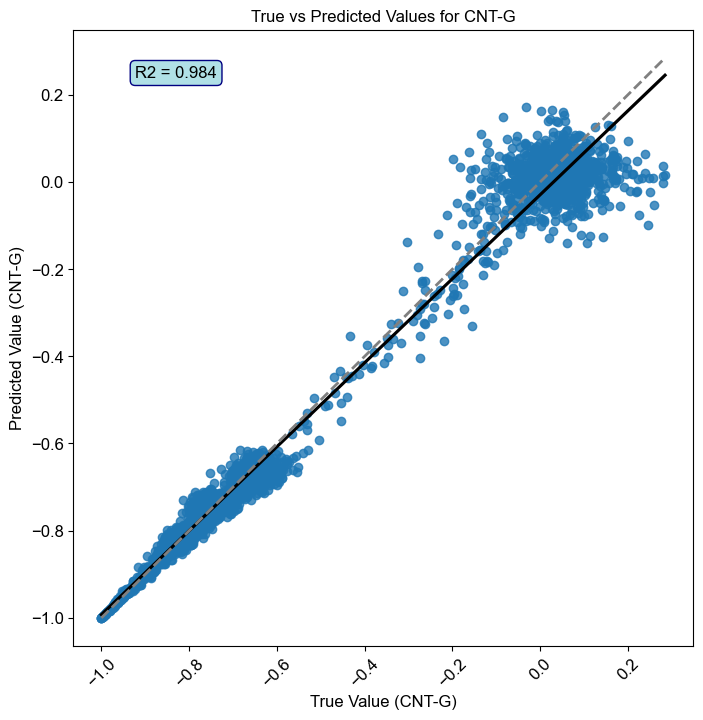

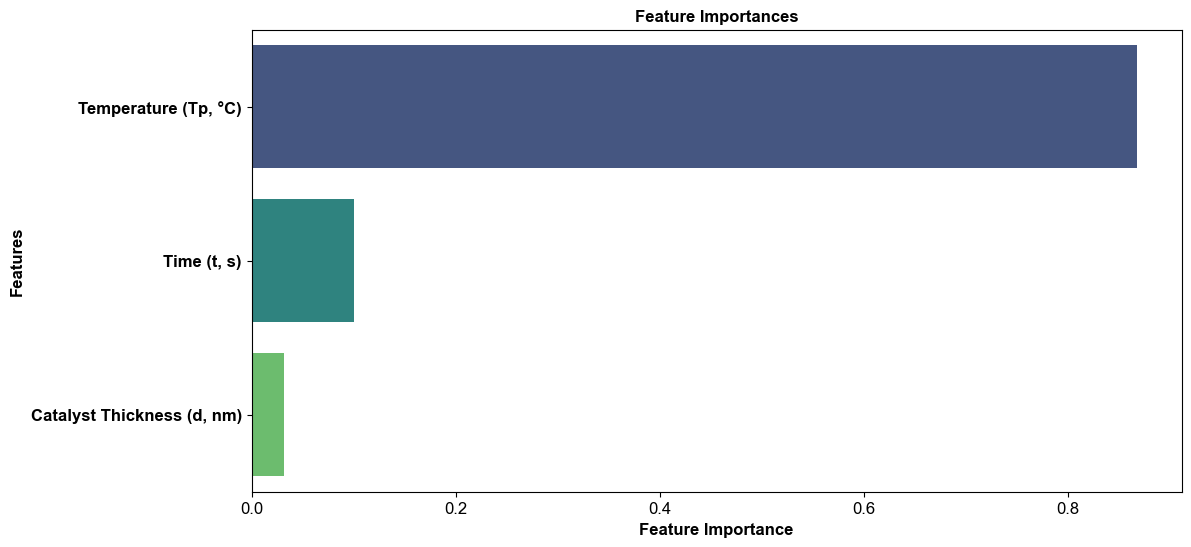

In [41]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [42]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)
model_prediction = xgb_model.predict(X_test)

R^2 CNT-G: 0.9901999831199646
MAE CNT-G: 0.019280966012383702
MSE CNT-G: 0.0011675810222981824
RMSE CNT-G: 0.0341698847276104


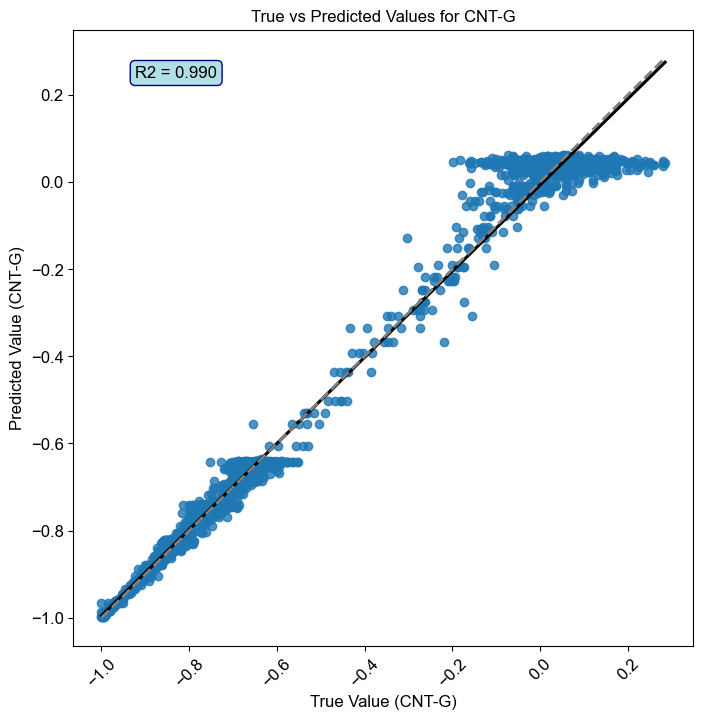

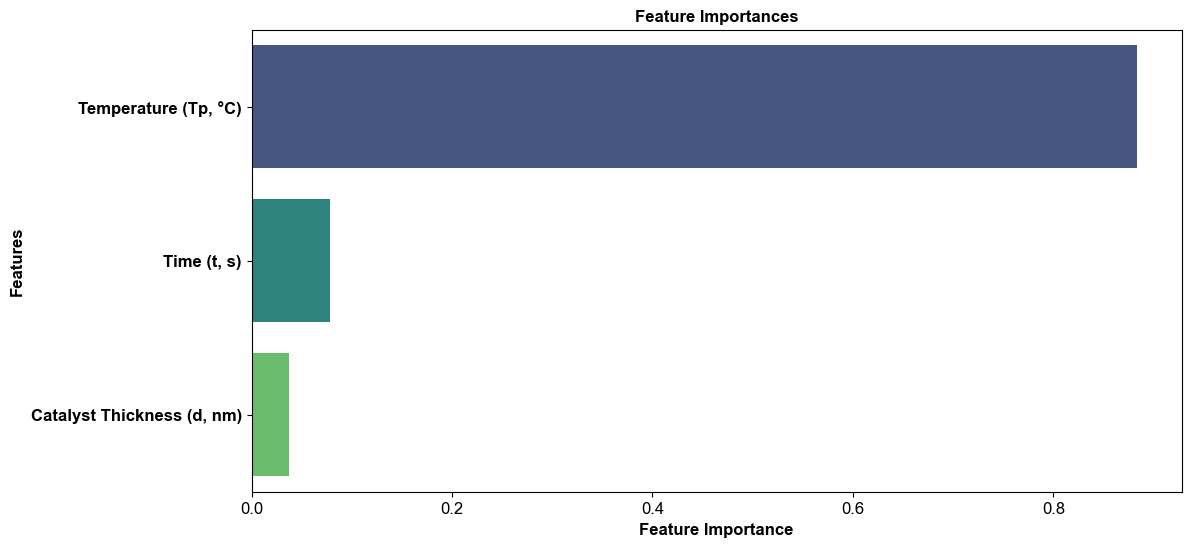

In [43]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [44]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)
model_prediction = ann_model.predict(X_test)

R^2 CNT-G: 0.989709015638789
MAE CNT-G: 0.021286649297292726
MSE CNT-G: 0.0012260728776033315
RMSE CNT-G: 0.035015323468494924


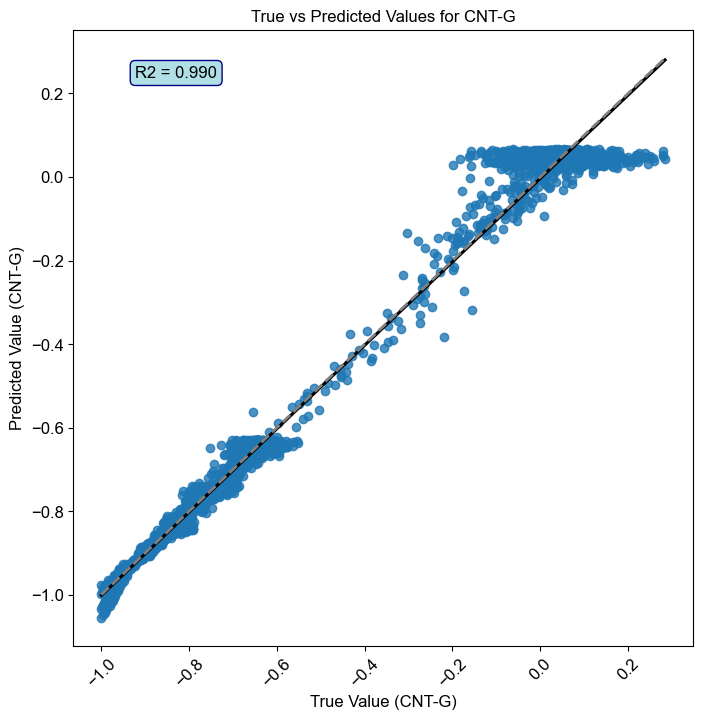

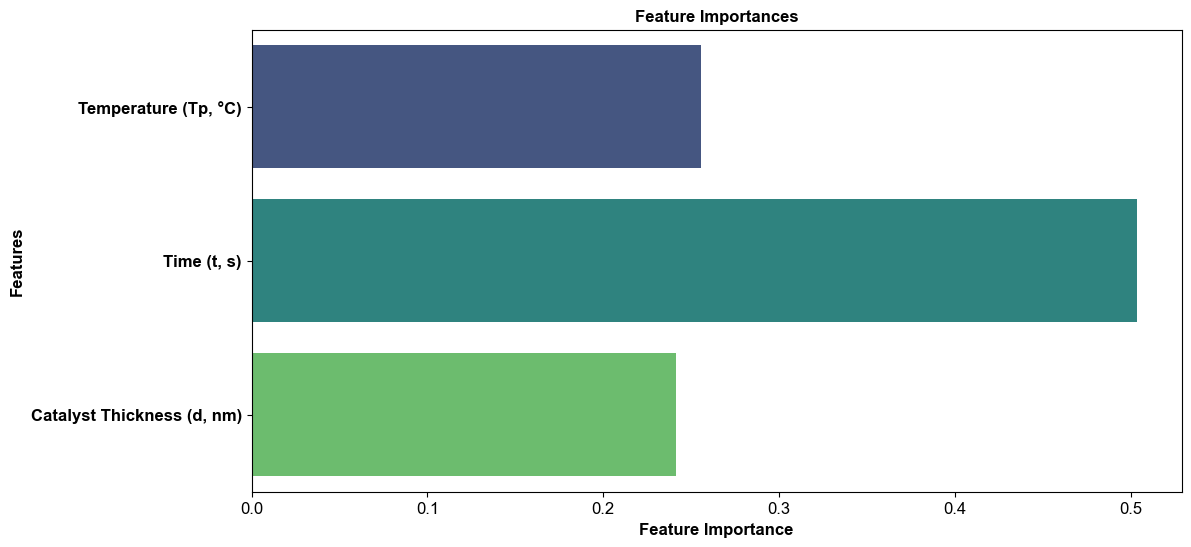

In [45]:
print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### Train on only simulated data and test both

In [46]:
test_experiment_numbers = [3, 19, 37, 100, 137, 138, 139]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Separate the training set
training_set = simulated_data[~simulated_data['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)

Training set shape: (158532, 5)
Test set shape: (9270, 5)


In [47]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

Number of Exp for train:  132
Number of Exp for test:  7
X_train shape: (158532, 3)
Y_train shape: (158532, 1)
X_test shape: (9270, 3)
Y_test shape: (9270, 1)


In [48]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9807096566293041
MAE CNT-G: 0.029903239121114124
MSE CNT-G: 0.0016302272691579623
RMSE CNT-G: 0.04037607297841089


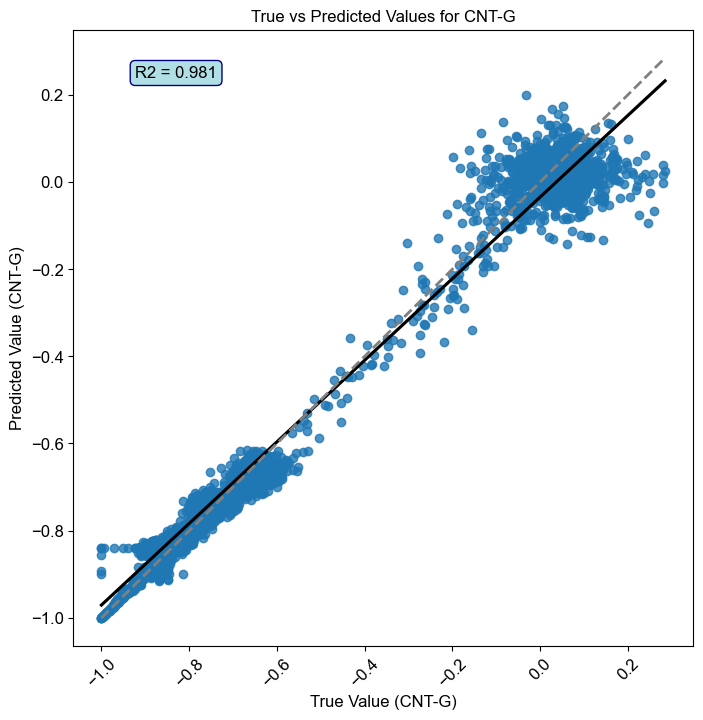

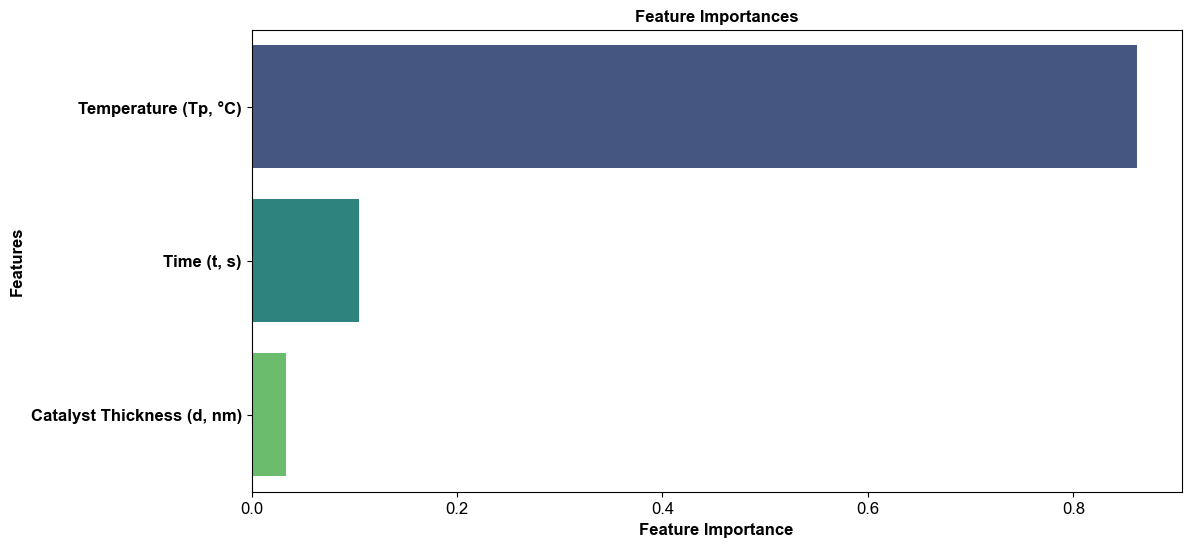

In [49]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

In [50]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.985904335975647
MAE CNT-G: 0.025502565899241887
MSE CNT-G: 0.0011912236008498672
RMSE CNT-G: 0.03451410727296691


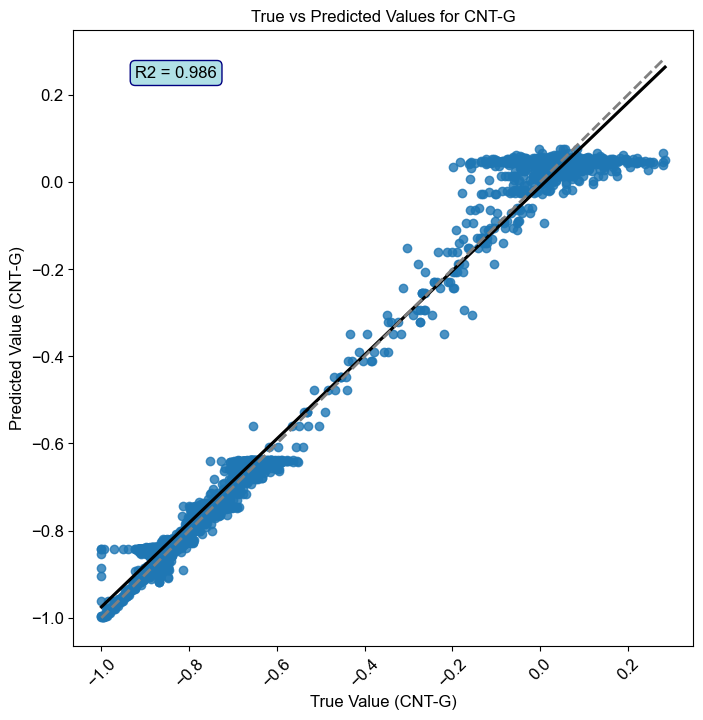

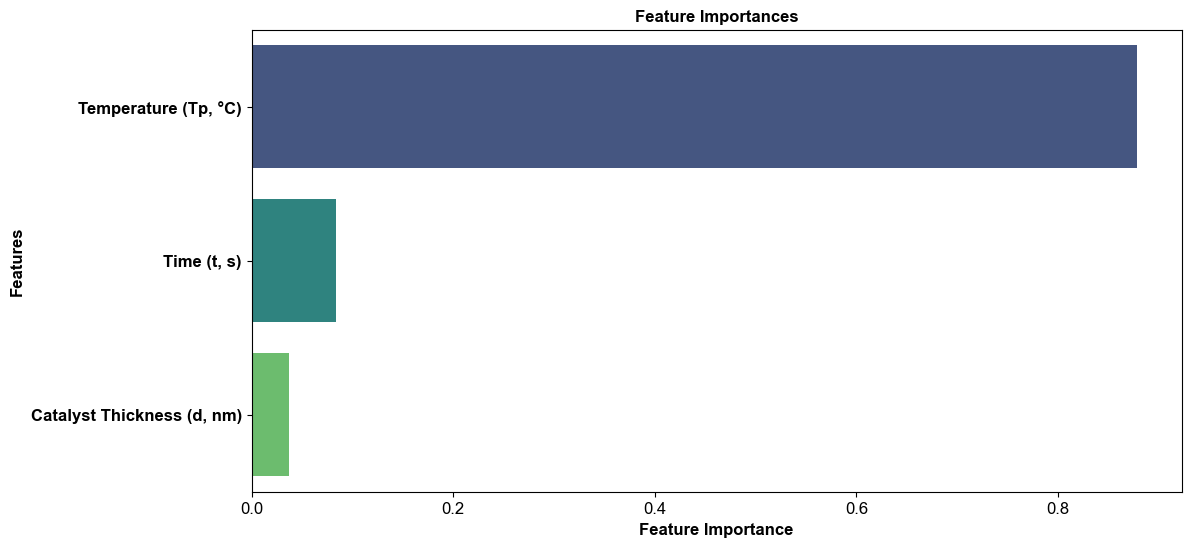

In [51]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

In [52]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: -8.189022614104632
MAE CNT-G: 0.35864340274607276
MSE CNT-G: 0.7765644682706424
RMSE CNT-G: 0.8812289533774083


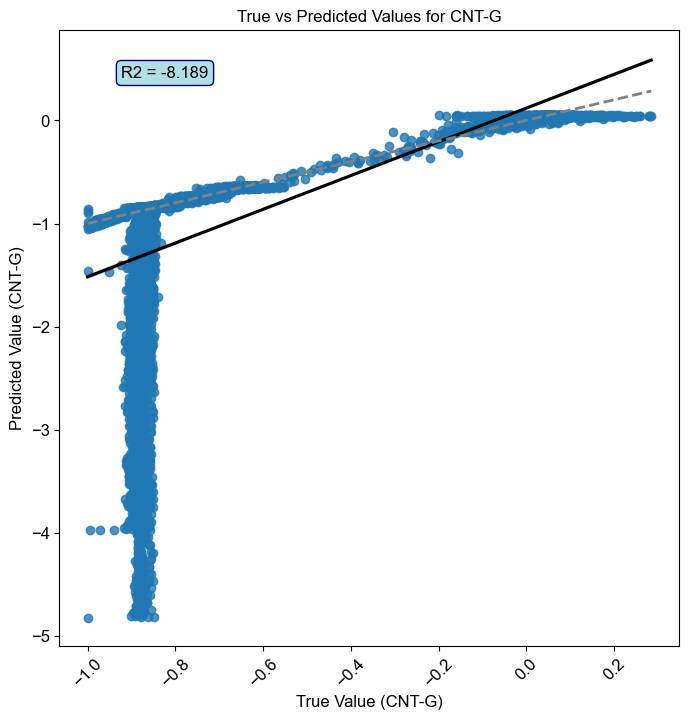

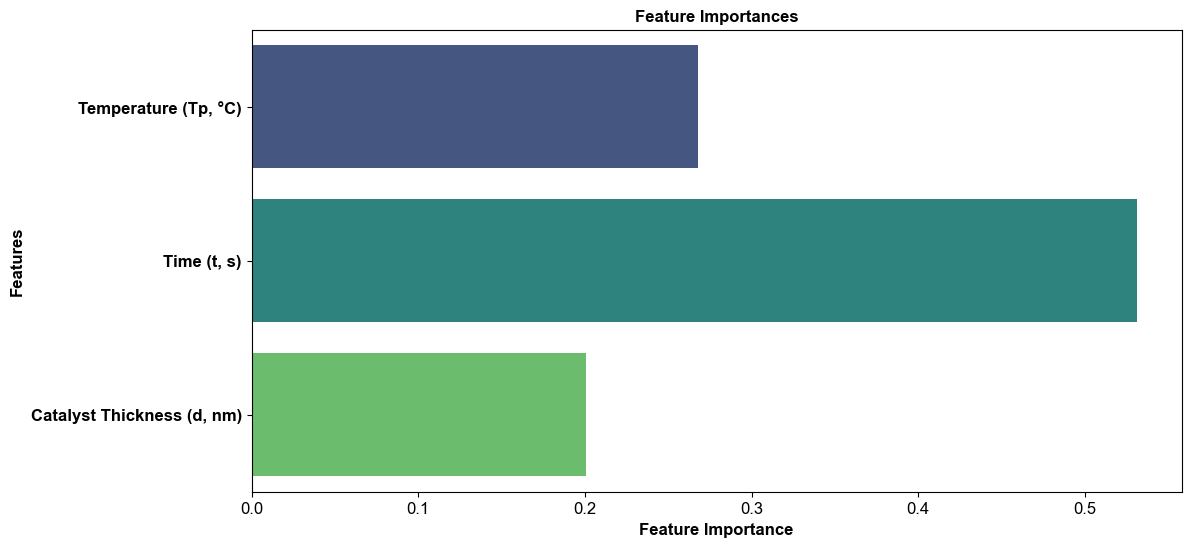

In [53]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### $\color{red}{\text{Train with both data and test both}}$


In [54]:
test_experiment_numbers = [3, 19, 37, 100, 138]

# Separate the test set
test_set = full_dataset[full_dataset['Experiment Number'].isin(test_experiment_numbers)]
test_set_exp = full_dataset[full_dataset['Experiment Number'].isin([138])]
test_set_sim = full_dataset[full_dataset['Experiment Number'].isin([3, 19, 37, 100])]

# Separate the training set
training_set = full_dataset[~full_dataset['Experiment Number'].isin(test_experiment_numbers)]

# Display the shapes of the resulting datasets
print("Training set shape:", training_set.shape)
print("Test set shape:", test_set.shape)
print("Test set EXP shape:", test_set_exp.shape)
print("Test set SIM shape:", test_set_sim.shape)

Training set shape: (161514, 5)
Test set shape: (6288, 5)
Test set EXP shape: (1484, 5)
Test set SIM shape: (4804, 5)


In [55]:
Y_train = training_set[target]
X_train = training_set.drop(target, axis=1)
print('Number of Exp for train: ',len(X_train['Experiment Number'].unique()))
X_train = X_train.drop("Experiment Number", axis=1)

Y_test = test_set[target]
X_test = test_set.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test['Experiment Number'].unique()))
X_test = X_test.drop("Experiment Number", axis=1)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

print("-----------------------")
Y_test_exp = test_set_exp[target]
X_test_exp = test_set_exp.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test_exp['Experiment Number'].unique()))
X_test_exp = X_test_exp.drop("Experiment Number", axis=1)
print("X_test EXP shape:", X_test_exp.shape)
print("Y_test EXP shape:", Y_test_exp.shape)

print("-----------------------")
Y_test_sim = test_set_sim[target]
X_test_sim = test_set_sim.drop(target, axis=1)
print('Number of Exp for test: ',len(X_test_sim['Experiment Number'].unique()))
X_test_sim = X_test_sim.drop("Experiment Number", axis=1)
print("X_test EXP shape:", X_test_sim.shape)
print("Y_test EXP shape:", Y_test_sim.shape)

Number of Exp for train:  134
Number of Exp for test:  5
X_train shape: (161514, 3)
Y_train shape: (161514, 1)
X_test shape: (6288, 3)
Y_test shape: (6288, 1)
-----------------------
Number of Exp for test:  1
X_test EXP shape: (1484, 3)
Y_test EXP shape: (1484, 1)
-----------------------
Number of Exp for test:  4
X_test EXP shape: (4804, 3)
Y_test EXP shape: (4804, 1)


In [56]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

R^2 CNT-G: 0.9832030299837415
MAE CNT-G: 0.025829107528171528
MSE CNT-G: 0.001801814629966435
RMSE CNT-G: 0.04244778710329238


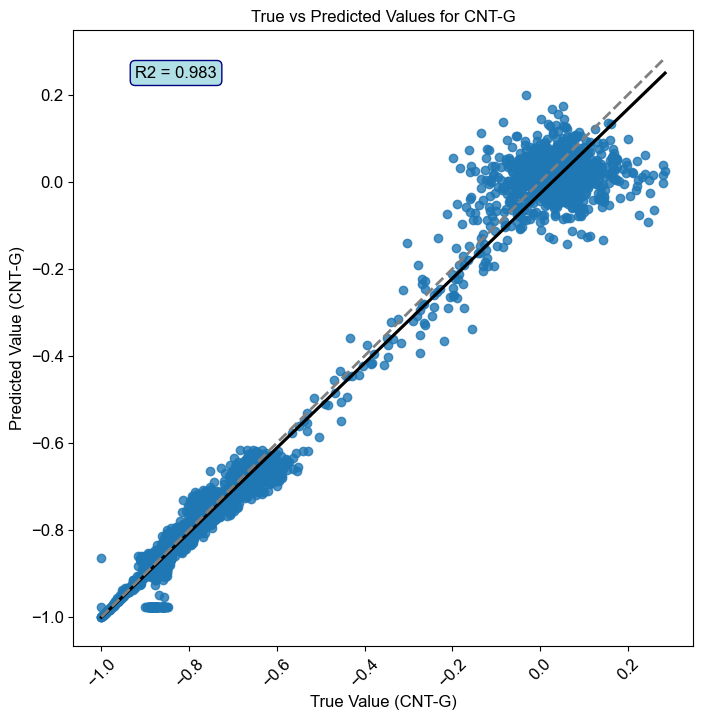

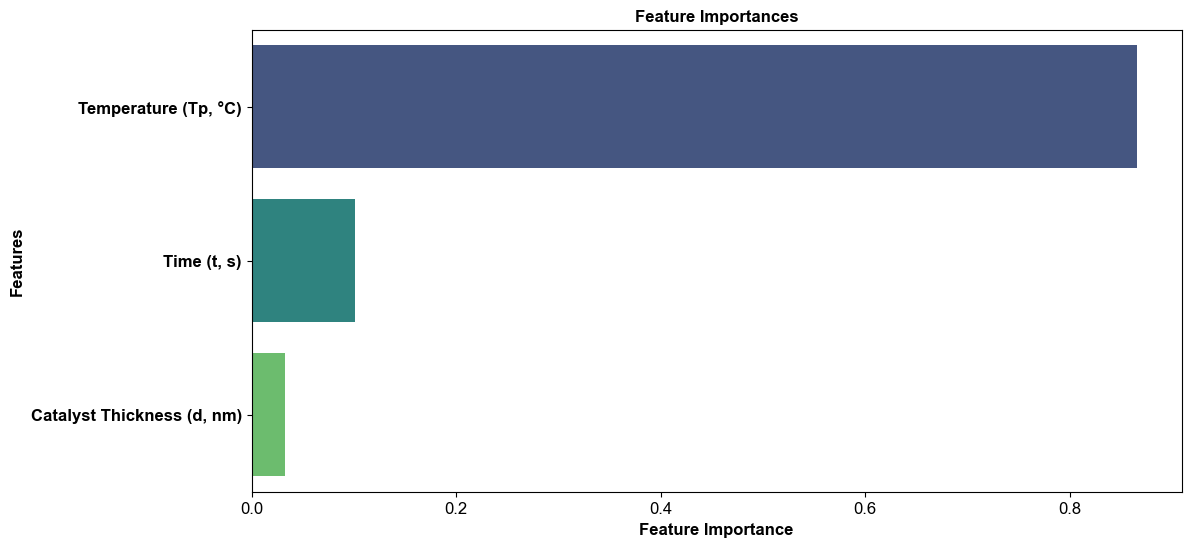

In [57]:
model_prediction = rf_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(rf_model,features)

### Test on EXP data

In [58]:
# model_prediction = rf_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(rf_model,features)

### Test on SIM data

R^2 CNT-G: 0.9842141290365893
MAE CNT-G: 0.026416166825186035
MSE CNT-G: 0.0018807363375787072
RMSE CNT-G: 0.043367457126037574


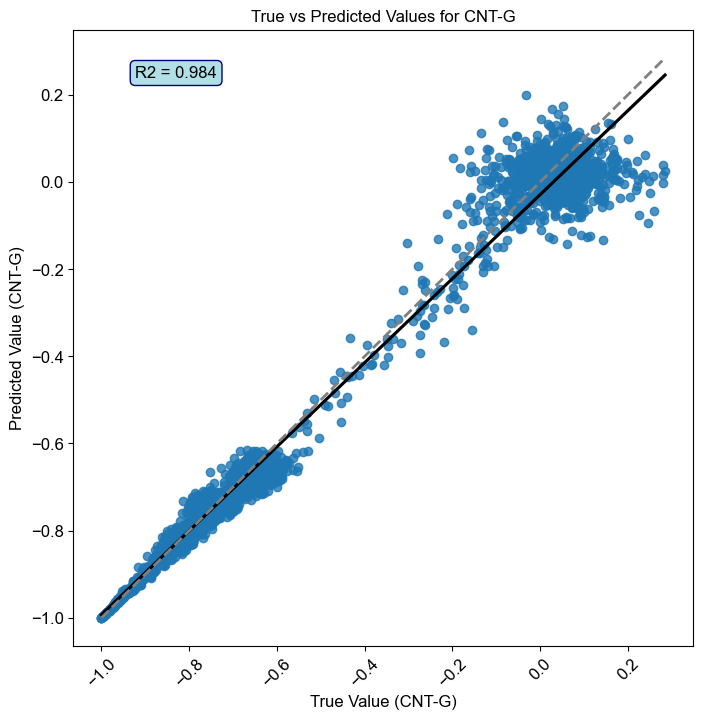

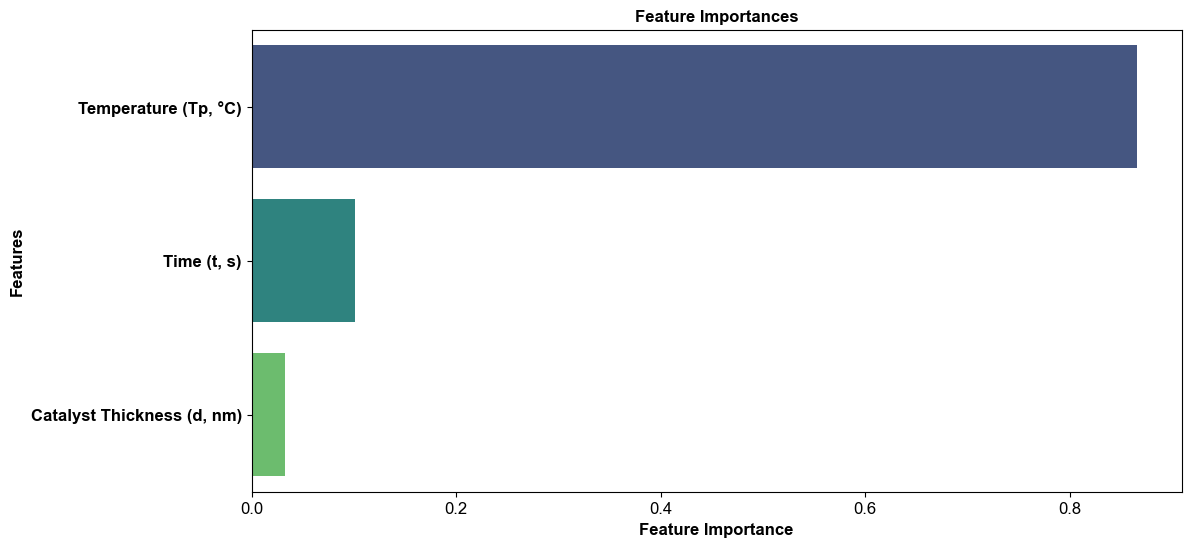

In [59]:
model_prediction = rf_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(rf_model,features)

In [60]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100, random_state=42)
xgb_model.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

R^2 CNT-G: 0.9911718368530273
MAE CNT-G: 0.017457865125493154
MSE CNT-G: 0.0009469992761454045
RMSE CNT-G: 0.030773353345799098


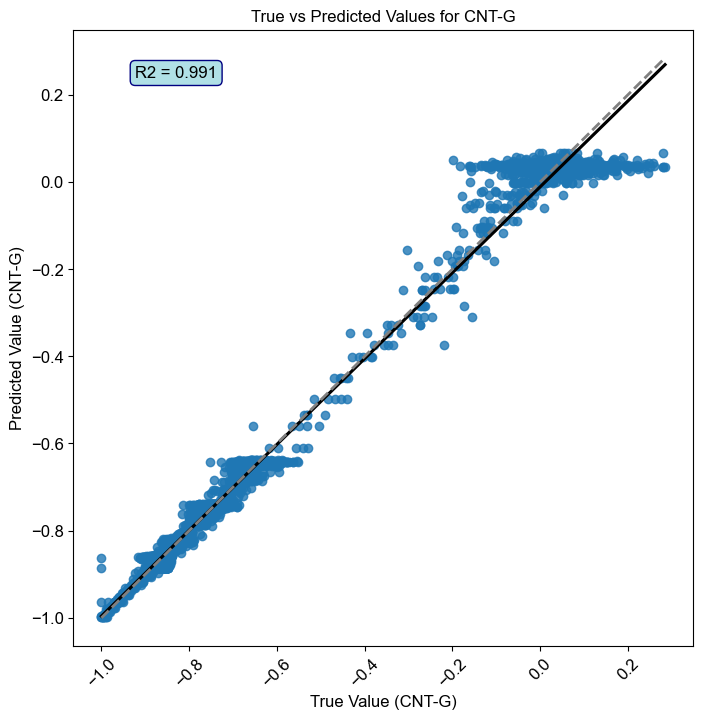

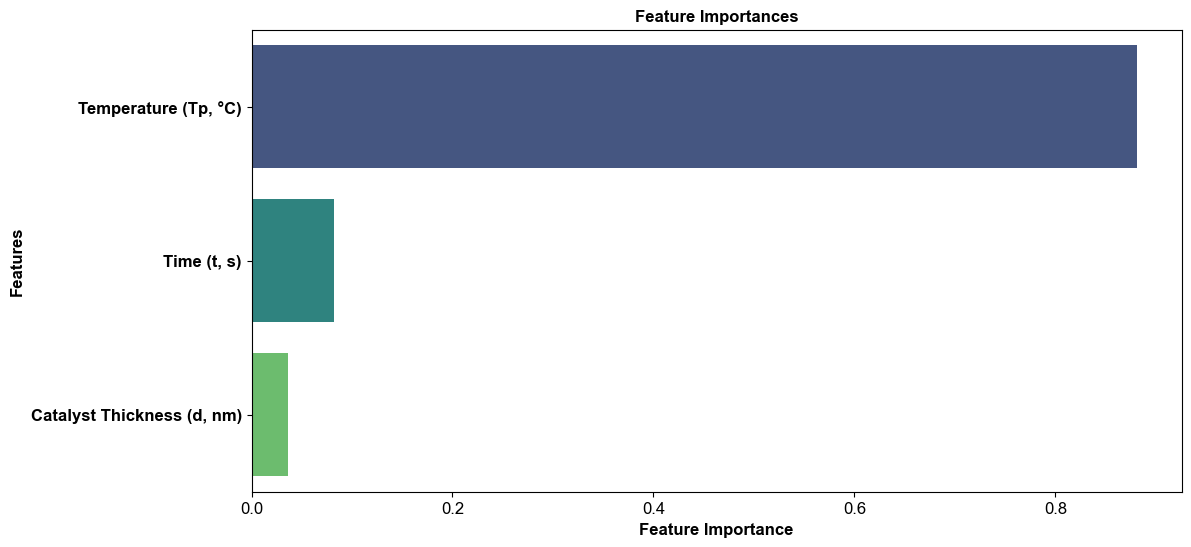

In [61]:
model_prediction = xgb_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(xgb_model,features)

### Test on EXP data

In [62]:
# model_prediction = xgb_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(xgb_model,features)

### Test on SIM data

R^2 CNT-G: 0.9901774525642395
MAE CNT-G: 0.019421871668541413
MSE CNT-G: 0.0011702618845397682
RMSE CNT-G: 0.034209090671044856


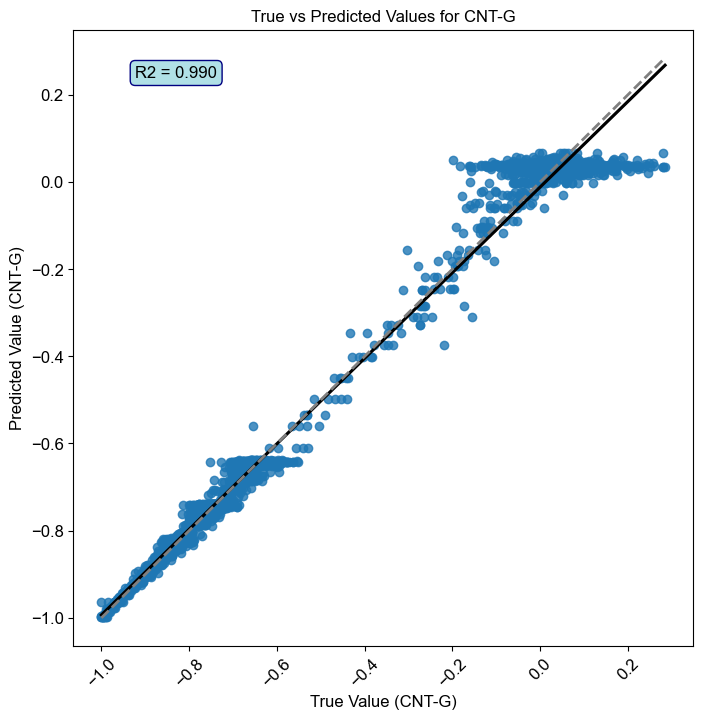

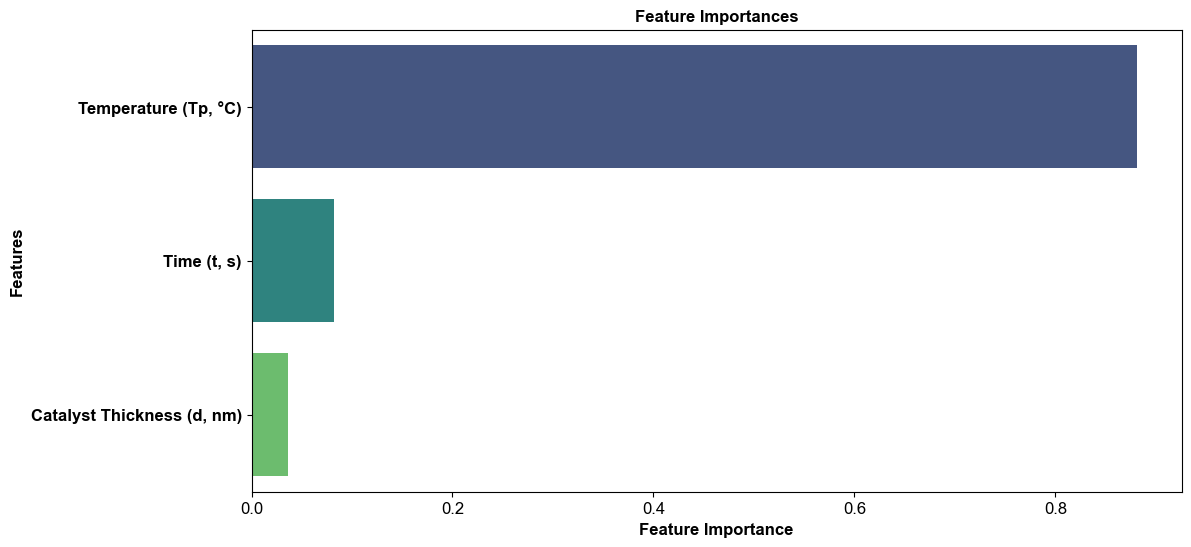

In [63]:
model_prediction = xgb_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(xgb_model,features)

In [64]:
model_parm = {
    'solver': 'lbfgs',
    'hidden_layer_sizes': (64,32),
    'alpha': 0.1,
    'activation': 'relu'
}
ann_model = MLPRegressor(max_iter=1000, random_state=42, **model_parm)
ann_model.fit(X_train, Y_train)

MLPRegressor(alpha=0.1, hidden_layer_sizes=(64, 32), max_iter=1000,
             random_state=42, solver='lbfgs')

R^2 CNT-G: 0.9861405719182775
MAE CNT-G: 0.022427187521993373
MSE CNT-G: 0.0014867038672119759
RMSE CNT-G: 0.038557799045225286


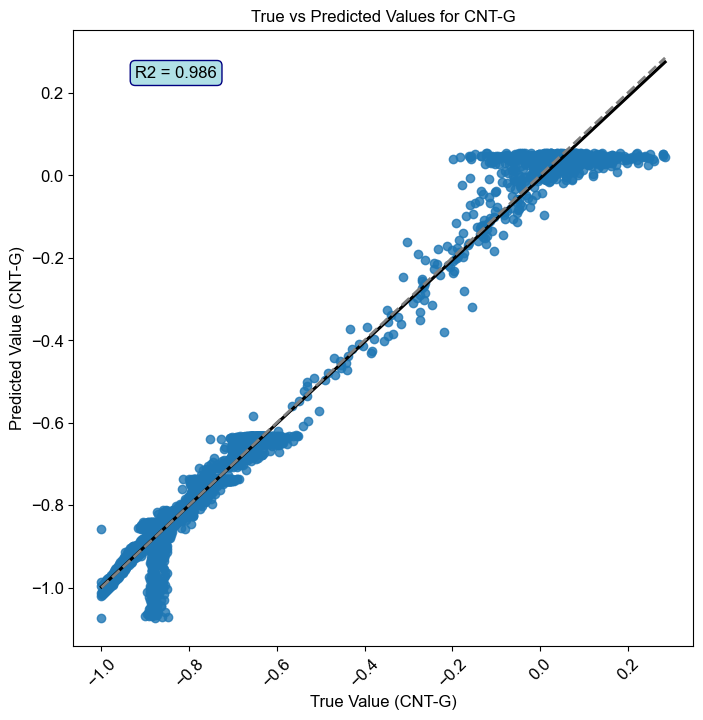

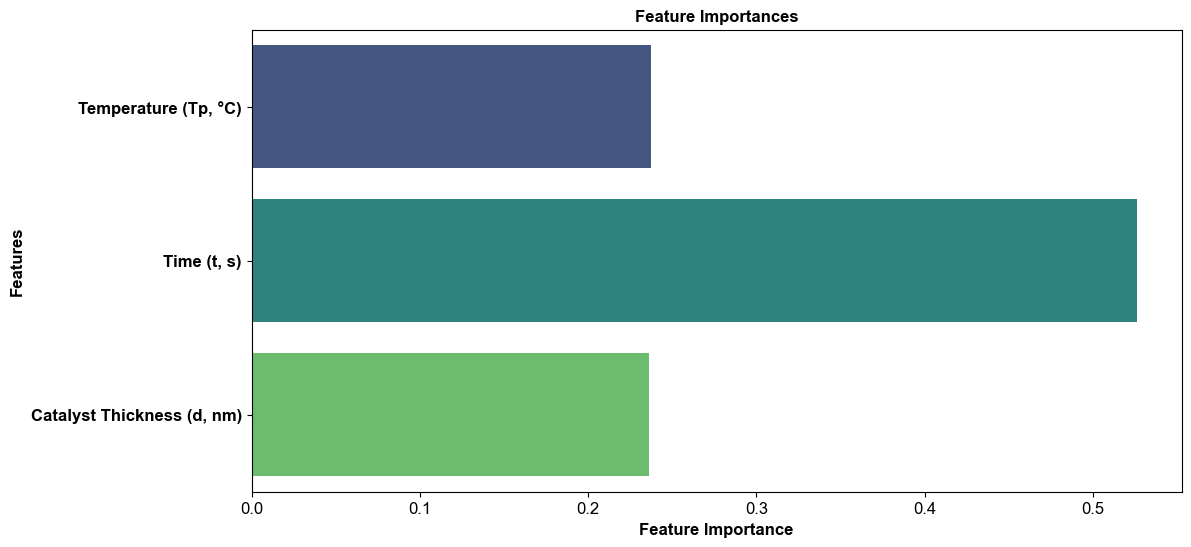

In [65]:
model_prediction = ann_model.predict(X_test)

print("R^2 CNT-G:", r2_score(Y_test, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test,model_prediction))
true_pred_plot(Y_test, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

### Test on EXP data

In [66]:
# model_prediction = ann_model.predict(X_test_exp)

# print("R^2 CNT-G:", r2_score(Y_test_exp, model_prediction))
# print("MAE CNT-G:",mean_absolute_error(Y_test_exp,model_prediction))
# print("MSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction)** 2)
# print("RMSE CNT-G:",root_mean_squared_error(Y_test_exp,model_prediction))
# true_pred_plot(Y_test_exp, model_prediction, "CNT-G")
# fea(ann_model,features, model_name="ann")

### Test on SIM data

R^2 CNT-G: 0.9900360046410426
MAE CNT-G: 0.020610896379375993
MSE CNT-G: 0.0011871152489775572
RMSE CNT-G: 0.034454538873384406


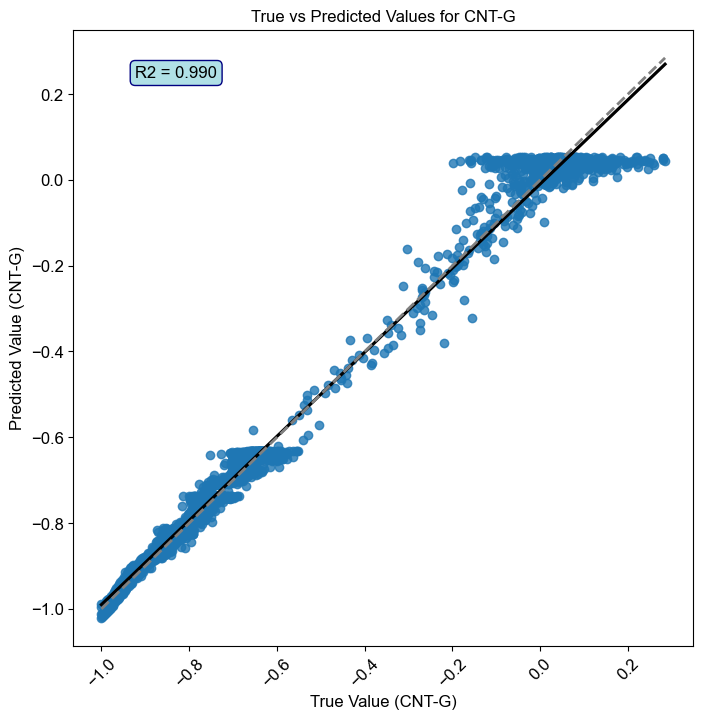

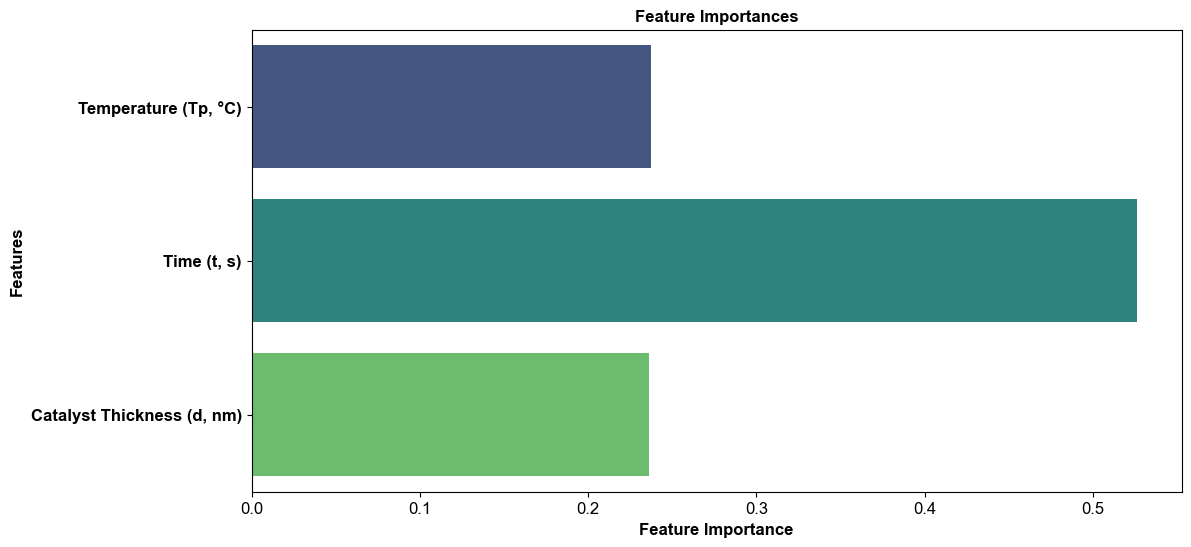

In [67]:
model_prediction = ann_model.predict(X_test_sim)

print("R^2 CNT-G:", r2_score(Y_test_sim, model_prediction))
print("MAE CNT-G:",mean_absolute_error(Y_test_sim,model_prediction))
print("MSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction)** 2)
print("RMSE CNT-G:",root_mean_squared_error(Y_test_sim,model_prediction))
true_pred_plot(Y_test_sim, model_prediction, "CNT-G")
fea(ann_model,features, model_name="ann")

## Necessary Graph

In [68]:
results_col = ['Model', 'R2- Simulated Test', 'R2- Simulated & Experimental Validation']
models_list = ['Random Forest', 'XGBoost', 'ANN']
r2_sim_list = [0.984, 0.990, 0.990]
r2_exp_sim_list = [0.983, 0.991, 0.986]
rmse_sim_list = [0.043, 0.0342, 0.0344]
rmse_exp_sim_list = [0.042, 0.030, 0.039]
mae_sim_list = [0.026, 0.0194, 0.021]
mae_exp_sim_list = [0.026, 0.017, 0.022]

# plot_dual_y_axis(models_list, r2_sim_list, rmse_sim_list, mae_sim_list, r2_exp_sim_list, rmse_exp_sim_list, mae_exp_sim_list)

In [69]:
def plot_dual_y_axis_single_matrices(models_list, r2_exp_sim_list, rmse_exp_sim_list, mae_exp_sim_list, 
                                     save_path='graphs/output.png', title='Simulated Data'):
    import matplotlib.pyplot as plt
    import numpy as np

    fig, ax1 = plt.subplots(figsize=(9, 6))

    x = np.arange(len(models_list))
    width = 0.3

    # --- Plot R² on the left y-axis ---
    ax1.set_xlabel('Models', fontsize=20, fontweight='bold')
    ax1.set_ylabel('R²', fontsize=20, fontweight='bold')

    # Base bars for R² (solid fill only)
    bars_r2_base = ax1.bar(x, r2_exp_sim_list, width,
                           color='lightgray', edgecolor='black', label='R²')
    # Overlay bars with hatch for R² (no facecolor, hatch only)
    ax1.bar(x, r2_exp_sim_list, width,
            facecolor='none', edgecolor='black', hatch='////')

    ax1.tick_params(axis='y', labelsize=20, length=6, width=1.5)
    ax1.set_ylim(0.9, 1.0)

    y_ticks = np.linspace(0.9, 1.0, num=5)
    ax1.set_yticks(y_ticks)
    for label in ax1.get_yticklabels():
        label.set_fontweight('bold')

    # Add R² annotations
    for bar in bars_r2_base:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.001, f'{height:.3f}', 
                 ha='center', va='bottom', fontsize=15, fontweight='bold', rotation=45)

    # --- Plot RMSE and MAE on the right y-axis ---
    ax2 = ax1.twinx()
    ax2.set_ylabel('RMSE / MAE', fontsize=20, fontweight='bold')

    max_val = max(rmse_exp_sim_list + mae_exp_sim_list) * 1.2
    # Base bars for RMSE
    bars_rmse_base = ax2.bar(x - width/2, rmse_exp_sim_list, width,
                             color='wheat', edgecolor='black', label='RMSE')
    # Overlay bars for RMSE with colored hatch lines
    # For example, use red hatches
    ax2.bar(x - width/2, rmse_exp_sim_list, width,
            facecolor='none', edgecolor='red', hatch='\\\\\\\\')

    # Base bars for MAE
    bars_mae_base = ax2.bar(x + width/2, mae_exp_sim_list, width,
                            color='palegreen', edgecolor='black', label='MAE')
    # Overlay bars for MAE with dots hatch in another color (e.g., blue)
    ax2.bar(x + width/2, mae_exp_sim_list, width,
            facecolor='none', edgecolor='blue', hatch='...')

    ax2.tick_params(axis='y', labelsize=20, length=6, width=1.5)
    ax2.set_ylim(0, max_val)

    y_ticks_ax2 = np.linspace(0, max_val, num=5)
    ax2.set_yticks(y_ticks_ax2)
    for label in ax2.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(20)

    # Add RMSE and MAE annotations
    vertical_offset = max_val * 0.005
    for bars in [bars_rmse_base, bars_mae_base]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2, height + vertical_offset, f'{height:.3f}', 
                     ha='center', va='bottom', fontsize=15, fontweight='bold', rotation=45)

    # Customize x-axis ticks
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_list, fontsize=20, fontweight='bold')
    for label in ax1.get_xticklabels():
        label.set_fontweight('bold')
        label.set_fontsize(14)

    # Add legends
    # Create custom legend patches since we have two layers for each bar group
    import matplotlib.patches as mpatches
    r2_patch = mpatches.Patch(facecolor='lightgray', edgecolor='black', hatch='////', label='R²')
    rmse_patch = mpatches.Patch(facecolor='wheat', edgecolor='red', hatch='\\\\\\\\', label='RMSE')
    mae_patch = mpatches.Patch(facecolor='palegreen', edgecolor='blue', hatch='...', label='MAE')

    # Since both ax1 and ax2 have bars, we can just use ax1 for the legend
    # ax1.legend(handles=[r2_patch, rmse_patch, mae_patch], loc='upper left')
    # Add legends inside the plot area
    ax1.legend(handles = [r2_patch], loc='upper left', bbox_to_anchor=(0.15, 1))
    ax2.legend(handles=[rmse_patch, mae_patch], loc='upper right', bbox_to_anchor=(0.85, 1))

    plt.tight_layout()
    plt.subplots_adjust(top=1.2)
    ax1.set_title(title, fontsize=20, fontweight='bold')

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


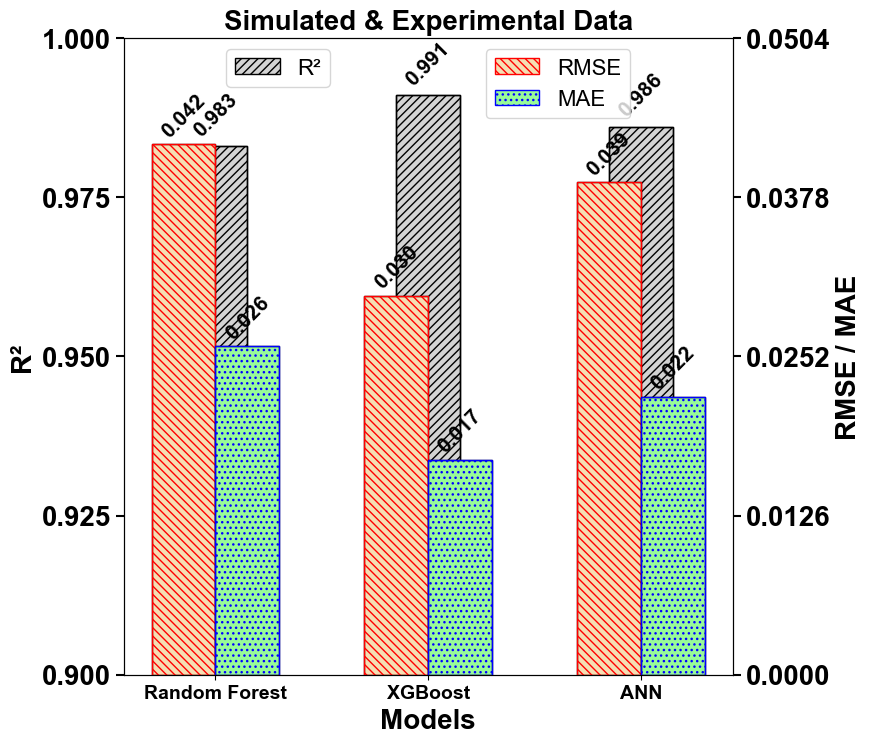

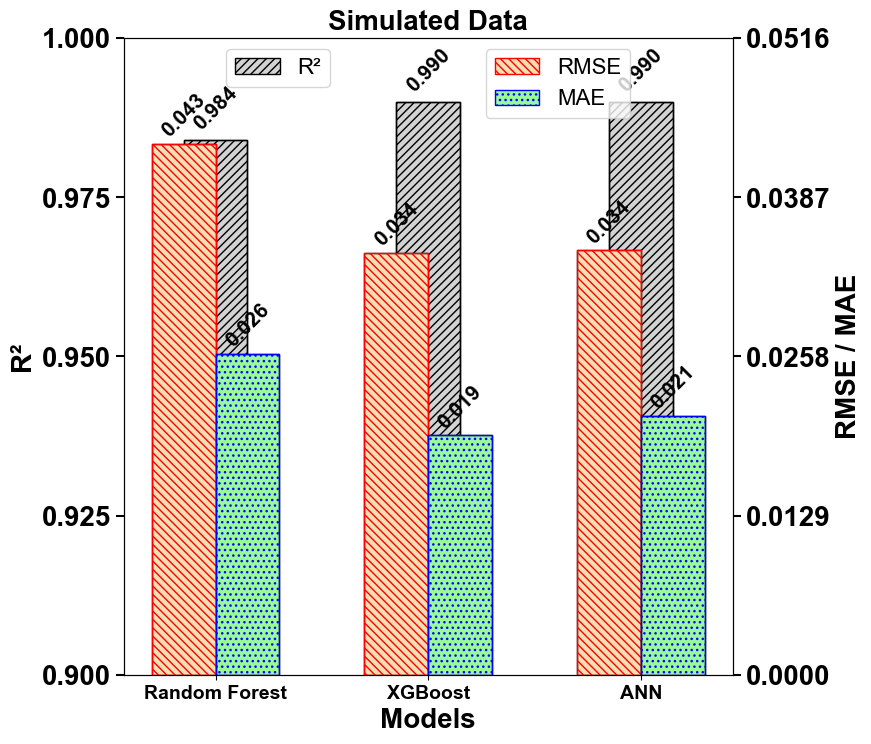

In [70]:
plot_dual_y_axis_single_matrices(models_list, r2_exp_sim_list, rmse_exp_sim_list, mae_exp_sim_list, save_path = 'graphs/sim_exp_matrices.png', title='Simulated & Experimental Data')
plot_dual_y_axis_single_matrices(models_list, r2_sim_list, rmse_sim_list, mae_sim_list, save_path = 'graphs/sim_matrices.png', title='Simulated Data')

(6288,)


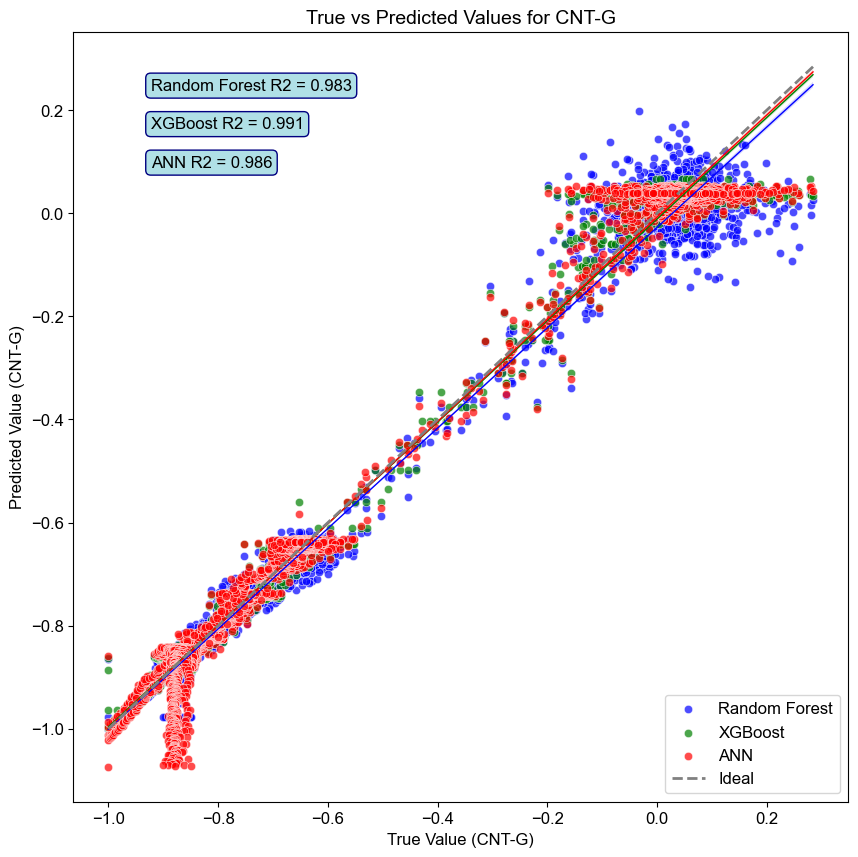

In [73]:
true_pred_plot_multiple(
    Y_test,
    [rf_model.predict(X_test).ravel(), xgb_model.predict(X_test).ravel(), ann_model.predict(X_test).ravel()],
    ["Random Forest", "XGBoost", "ANN"],
    "CNT-G"
)

In [80]:
def true_pred_plot_subplots(y_test, predictions, model_names, target_variable, save_path='graphs/true_pred_subplots.png', font_size=20, model_highlight=3):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    from sklearn.metrics import r2_score

    num_models = len(model_names)
    fig, axes = plt.subplots(1, num_models, figsize=(15, 5), sharex=True, sharey=True)

    y_test = np.array(y_test).ravel()

    for i, (y_pred, model_name, ax) in enumerate(zip(predictions, model_names, axes)):
        y_pred = np.array(y_pred).ravel()

        # Scatter plot
        sns.scatterplot(x=y_test, y=y_pred, ax=ax, alpha=0.7)
        
        # Regression line
        sns.regplot(x=y_test, y=y_pred, ax=ax, scatter=False, color='black', line_kws={'linewidth': 1})

        # Add diagonal reference line
        ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='gray', linewidth=2)

        # Title and labels
        ax.set_title(f"{model_name} - {target_variable}", fontsize=font_size, fontweight='bold')
        ax.set_xlabel(f"True Value ({target_variable})", fontsize=font_size, fontweight='bold')
        ax.set_ylabel(f"Predicted Value ({target_variable})", fontsize=font_size, fontweight='bold')

        # Reduce and customize y-axis ticks
        y_ticks = np.round(np.linspace(min(y_test), max(y_test), num=5), 2)  # Fewer y-axis ticks
        ax.set_yticks(y_ticks)
        ax.tick_params(axis='y', which='major', labelsize=font_size, width=1.5, length=6, labelcolor='black')
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')  # Make y-axis labels bold

        # Reduce and customize x-axis ticks
        x_ticks = np.round(np.linspace(min(y_test), max(y_test), num=5), 2)
        ax.set_xticks(x_ticks)
        ax.tick_params(axis='x', which='major', labelsize=font_size, width=1.5, length=6, labelcolor='black')
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')  # Make x-axis labels bold

        # Calculate R2 score
        R2 = r2_score(y_test, y_pred)
        ax.annotate(f'R2 = {R2:.3f}', xy=(0.05, 0.9), xycoords='axes fraction',
                    ha='left', va='center', fontsize=font_size,
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

        # Make the last subplot's border thick and bold
        if i == model_highlight - 1:
            for spine in ax.spines.values():
                spine.set_linewidth(2.5)  # Thicker border
                spine.set_edgecolor('black')  # Bold black border

    # fig.suptitle("Test set performance", fontsize=18)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    plt.show()


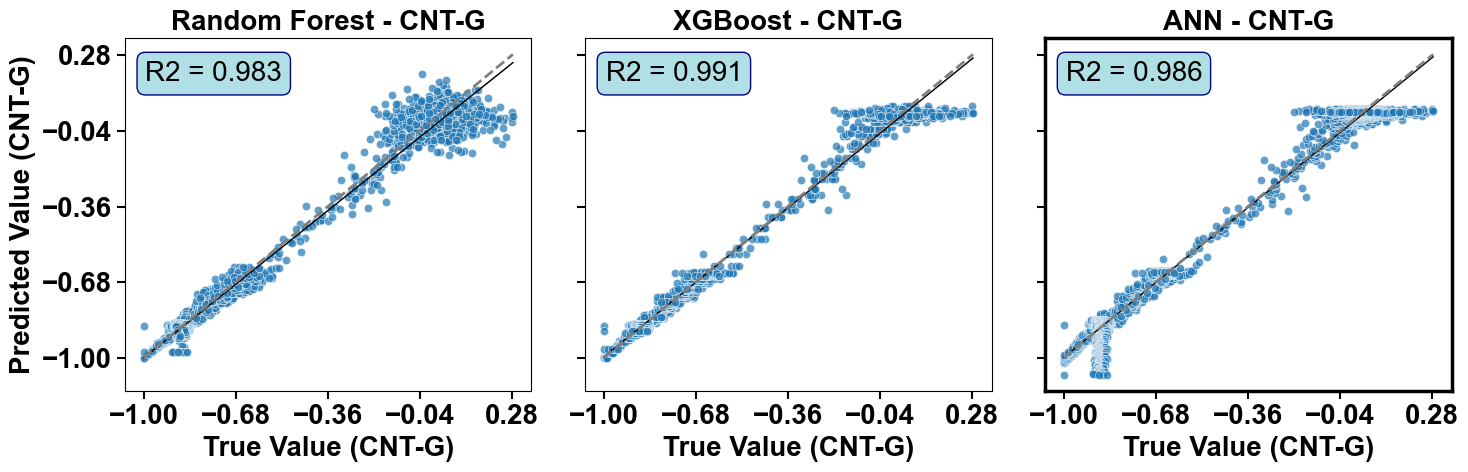

In [81]:
true_pred_plot_subplots(
    Y_test,
    [rf_model.predict(X_test), xgb_model.predict(X_test), ann_model.predict(X_test)],
    ["Random Forest", "XGBoost", "ANN"],
    "CNT-G"
)

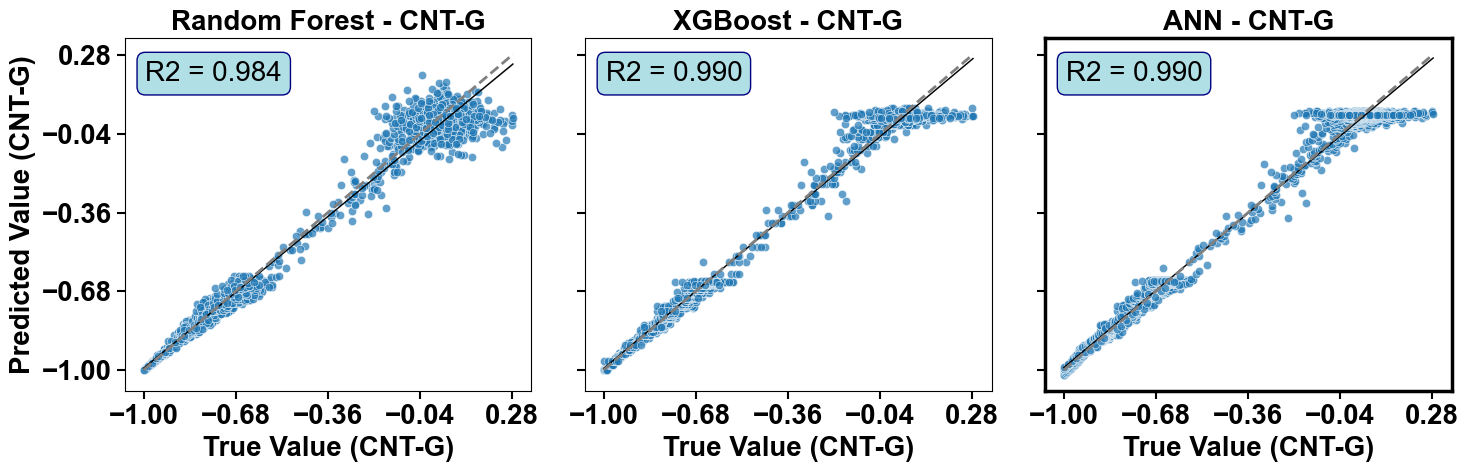

In [82]:
true_pred_plot_subplots(
    Y_test_sim,
    [rf_model.predict(X_test_sim), xgb_model.predict(X_test_sim), ann_model.predict(X_test_sim)],
    ["Random Forest", "XGBoost", "ANN"],
    "CNT-G",
    "graphs/true_pred_subplots_sim.png"
)

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import textwrap

def fea_side_by_side(models, features, model_names, save_path='graphs/important_features_subplot.png', 
                     title='Feature Importance Analysis', wrap_length=14, model_highlight=3):
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(5 * num_models, 6), sharey=True)
    
    # Wrap feature names
    wrapped_features = ['\n'.join(textwrap.wrap(feature, wrap_length)) for feature in features]
    
    for i, (model, model_name, ax) in enumerate(zip(models, model_names, axes)):
        if model_name.lower() == "ann":
            input_layer_weights = model.coefs_[0]
            feature_importance = np.abs(input_layer_weights).mean(axis=1)
            total_importance = np.sum(feature_importance)
            normalized_importance = feature_importance / total_importance
            feature_importances_df = pd.DataFrame({'Feature': wrapped_features, 'Importance': normalized_importance})
        else:
            feature_importances_df = pd.DataFrame({'Feature': wrapped_features, 'Importance': model.feature_importances_})
            feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
        
        # Plot feature importances
        sns.barplot(data=feature_importances_df, x='Importance', y='Feature', ax=ax, palette='viridis')
        ax.set_title(f'{model_name} Feature Importance', fontsize=20, fontweight='bold')
        ax.set_xlabel('Importance', fontsize=20, fontweight='bold')
        if i == 0:  # Only the first plot shows the y-axis label
            ax.set_ylabel('Features', fontsize=20, fontweight='bold')
        else:
            ax.set_ylabel('')

        # Reduce and customize y-axis ticks
        # y_ticks = np.round(np.linspace(min(y_test), max(y_test), num=5), 2)  # Fewer y-axis ticks
        # ax.set_yticks(y_ticks)
        # ax.tick_params(axis='y', which='major', labelsize=font_size, width=1.5, length=6, labelcolor='black')
        # for label in ax.get_yticklabels():
        #     label.set_fontweight('bold')  # Make y-axis labels bold
            
        # Reduce the number of x-ticks and make them bold
        x_ticks = np.linspace(0, feature_importances_df['Importance'].max(), num=5)  # Fewer x-ticks
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'{tick:.2f}' for tick in x_ticks], fontsize=20, fontweight='bold')
        
        # Make y-ticks bold and limit the number of features shown
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        ax.tick_params(axis='y', which='major', labelsize=20, length=6, width=1.5)

        # Make the highlighted subplot's border thick and bold
        if i == model_highlight - 1:
            for spine in ax.spines.values():
                spine.set_linewidth(2.5)  # Thicker border
                spine.set_edgecolor('black')  # Bold black border

    fig.suptitle(title, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight') 
    plt.show()


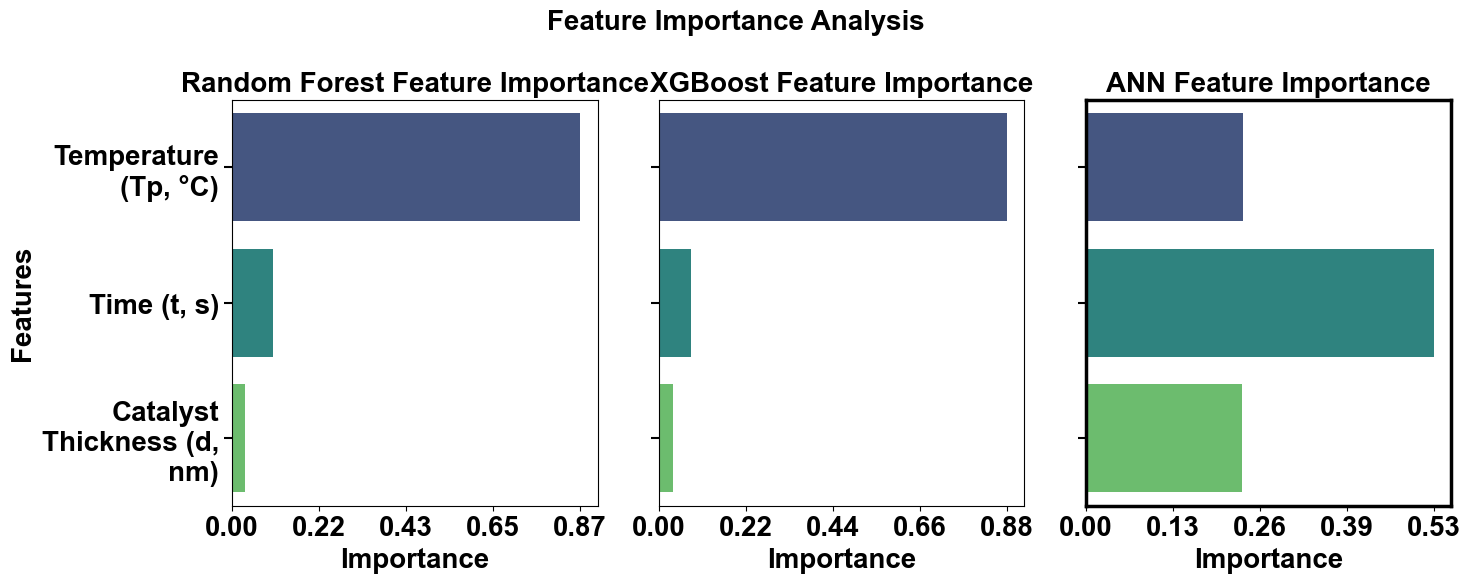

In [96]:
fea_side_by_side(
    models=[rf_model, xgb_model, ann_model],
    features=features,
    model_names=["Random Forest", "XGBoost", "ANN"]
)

## Generation experiment description

In [72]:
temperature_range = [600, 625, 650,675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
thickness_range = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]

In [73]:
min_temp = min(temperature_range)
max_temp = max(temperature_range)
temp = [int(temp) for temp in np.linspace(min_temp, max_temp, 100) if temp not in temperature_range]

min_thikness = min(thickness_range)
max_thikness = max(thickness_range)
thikness = [round(thikness,3) for thikness in np.linspace(min_thikness, max_thikness, 100) if temp not in thickness_range]
thikness[0] = 0.61

print(temp)
print(thikness)

[604, 608, 612, 616, 620, 624, 628, 632, 636, 640, 644, 648, 652, 656, 660, 664, 668, 672, 676, 680, 684, 688, 692, 696, 701, 705, 709, 713, 717, 721, 725, 729, 733, 737, 741, 745, 749, 753, 757, 761, 765, 769, 773, 777, 781, 785, 789, 793, 797, 802, 806, 810, 814, 818, 822, 826, 830, 834, 838, 842, 846, 850, 854, 858, 862, 866, 870, 874, 878, 882, 886, 890, 894, 898, 903, 907, 911, 915, 919, 923, 927, 931, 935, 939, 943, 947, 951, 955, 959, 963, 967, 971, 975, 979, 983, 987, 991, 995]
[0.61, 0.614, 0.628, 0.642, 0.657, 0.671, 0.685, 0.699, 0.713, 0.727, 0.741, 0.756, 0.77, 0.784, 0.798, 0.812, 0.826, 0.84, 0.855, 0.869, 0.883, 0.897, 0.911, 0.925, 0.939, 0.954, 0.968, 0.982, 0.996, 1.01, 1.024, 1.038, 1.053, 1.067, 1.081, 1.095, 1.109, 1.123, 1.137, 1.152, 1.166, 1.18, 1.194, 1.208, 1.222, 1.236, 1.251, 1.265, 1.279, 1.293, 1.307, 1.321, 1.335, 1.349, 1.364, 1.378, 1.392, 1.406, 1.42, 1.434, 1.448, 1.463, 1.477, 1.491, 1.505, 1.519, 1.533, 1.547, 1.562, 1.576, 1.59, 1.604, 1.618, 1.63

In [74]:
full_dataset.columns

Index(['Experiment Number', 'Temperature (Tp, °C)', 'Time (t, s)',
       'Catalyst Thickness (d, nm)', 'CNT-G (micrometers/s)'],
      dtype='object')

In [75]:
# Create a dataframe with the specified columns
temperature = temp[0]
catalyst_thickness = thikness[0]
time_values = np.arange(0, 1201, 1)  # Time values from 0 to 1200

# Create the dataframe
df_new = pd.DataFrame({
    'Temperature (Tp, °C)': [temperature] * len(time_values),
    'Time (t, s)': time_values,
    'Catalyst Thickness (d, nm)': [catalyst_thickness] * len(time_values)
})
df_new['CNT-G (micrometers/s)'] = rf_model.predict(df_new)
df_new['Experiment Number'] = 1
df_new = df_new[full_dataset.columns]
df_new.head()

Experiment Number  Temperature (Tp, °C)  Time (t, s)  \
0                  1                   604            0   
1                  1                   604            1   
2                  1                   604            2   
3                  1                   604            3   
4                  1                   604            4   

   Catalyst Thickness (d, nm)  CNT-G (micrometers/s)  
0                        0.61               0.231398  
1                        0.61               0.231398  
2                        0.61               0.231398  
3                        0.61               0.231398  
4                        0.61               0.231398

Input:
1. Time of experiment 20 minutes
2. temperature
3. Catlyst thickness
4. catalyst type -- Fe, Aluminium Oxide -- fixed


Output:
1. lowest growth rate
2. highest growth rate
3. avergae growth rate
4. highest height in 20 minute.
5. height in 10 minutes.
5. time of height saturation?? or time when 90% growth height was achieved




In [76]:
import pandas as pd
from docx import Document
from statistics import mean
from datetime import datetime
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

df = df_new

def analyze_data(df):
    # Growth rate analysis
    growth_rates = df['CNT-G (micrometers/s)']
    total_growth = growth_rates.sum()
    target_growth = total_growth * 0.9
    df['Cumulative Growth'] = df['CNT-G (micrometers/s)'].cumsum()
    time_of_90_percent_growth = df.loc[df['Cumulative Growth'] >= target_growth, 'Time (t, s)'].iloc[0]
    
    # Calculate height over time
    df['Height (micrometers)'] = (df['CNT-G (micrometers/s)'] * df['Time (t, s)']).cumsum()
    
    # Calculate insights
    insights = {
        "lowest_growth_rate": growth_rates.min(),
        "highest_growth_rate": growth_rates.max(),
        "average_growth_rate": mean(growth_rates),
        "final_height": sum(growth_rates),
        "height_at_10_minutes": sum(df['CNT-G (micrometers/s)'][:df.shape[0]//2]),
        "time_of_reach_90%":  time_of_90_percent_growth, 
        "90% growth": target_growth
    }
    return insights

# Run analysis
insights = analyze_data(df)
current_datetime = datetime.now().strftime("%A, %B %d, %Y, %I:%M %p")
numeric_string = datetime.now().strftime("%Y%m%d_%H%M")

temp = df['Temperature (Tp, °C)'].iloc[0]
thickness = df['Catalyst Thickness (d, nm)'].iloc[0]


# Initialize Document
doc = Document()
# doc.add_heading('Experiment Report', level=1)

# Add the Experiment Report heading and center it
heading = doc.add_heading(level=1)
run = heading.add_run('Experiment Report\n\n')
run.font.size = Pt(24)

# Center the heading
heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

# Experiment Details
exp_num = df['Experiment Number'].iloc[0]
doc.add_heading(f'EXPERIMENT NUMBER : {exp_num}', level=2)
doc.add_paragraph(f'Experiment Identification: {current_datetime}')
doc.add_paragraph(f'Run ID: #{numeric_string}')  # Assuming a fixed run ID

# # Objective
# doc.add_heading('Objective', level=2)
# doc.add_paragraph('Assess voltage impact on nanotube growth and conductance at 750°C.')

# Objective
doc.add_heading('Objective', level=2)
doc.add_paragraph('Observe and predict CNT growth over time based on initial conditions such as temperature and catalyst thickness')

# Experimental Setup
# doc.add_heading('Experimental Setup', level=2)
# doc.add_paragraph('Temperature (°C): 750\nCatalyst Layer Thickness (nm): 20\nVoltage Range (V): 5V to 10V')

# Input Conditions
doc.add_heading('Input Conditions', level=2)
doc.add_paragraph(f"1. Time of experiment: 20 minutes\n2. Temperature: {temp}\n3. Catalyst thickness: {thickness}\n4. Catalyst type: Fe, Aluminium Oxide")

# Output
doc.add_heading('Output', level=2)
lowest_growth_rate = f"{insights['lowest_growth_rate']:.6f}"
highest_growth_rate = f"{insights['highest_growth_rate']:.6f}"
average_growth_rate = f"{insights['average_growth_rate']:.6f}"
final_height = f"{insights['final_height']:.6f} micrometers"
height_at_10_minutes = f"{insights['height_at_10_minutes']:.6f} micrometers" if insights['height_at_10_minutes'] is not None else "N/A"
time_of_saturation = f"{insights['time_of_reach_90%']} seconds" if insights['time_of_reach_90%'] is not None else "N/A"

doc.add_paragraph(
    f"1. Lowest growth rate: {lowest_growth_rate}\n"
    f"2. Highest growth rate: {highest_growth_rate}\n"
    f"3. Average growth rate: {average_growth_rate}\n"
    f"4. Final height: {final_height}\n"
    f"5. Height in 10 minutes: {height_at_10_minutes}\n"
    f"6. Time to reach 90% growth: {time_of_saturation}\n"
    f"7. 90% of Total growth: {time_of_saturation}\n"
)

# Observations
doc.add_heading('Observations', level=2)
observations = (
    "Based on this experiment, the growth rate shows an initial increase and "
    "appears to stabilize over time. The maximum growth rate was achieved at "
    f"{insights['highest_growth_rate']:.6f} micrometers/s, with saturation occurring around "
    f"{time_of_saturation}. The final height reached {insights['final_height']:.6f} micrometers."
)
doc.add_paragraph(observations)

# Save document
doc.save('experiment_report.docx')
